#### To use the Random Forest Survival analysis you will need to use the Pysurvival package.
To install this package please follow the instructions from this site https://square.github.io/pysurvival/installation.html
##### For MacOS users:
You will need to add two more lines besides the recommended 2 as shown below:
###### Note: please check which version of gcc do you have as it might be different from 9.3.0.



### To use the Random Forest Survival analysis we need to load the data and remove the colinear features

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import os

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import integrated_brier_score

from sklearn.model_selection import StratifiedKFold
from statistics import mean 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [3]:
# feature selection function by VIF and removing low variance features

def feature_select(file_name):
    data = pd.read_csv(file_name)

    data['time column']= data['FFLP_in_months']
    data['event column']= data['FFLP']

    data1=data.drop(columns=['filename'])
    lola=data1.iloc[:,0:255]

    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data1.columns, [time_column, event_column]).tolist()

    #VIF of 10 means that all the features with R^2 above 0.9 will removed
    X = lola
    data2 = calculate_vif_(X, 10)
    data2[['time column']] = lola[['time column']]

    #removing low variance features
    data_temp = data2
    for cols in data2.columns:
        if np.var(data2[cols]) == 0:
            print('Dropping: ' + cols)
            data_temp = data_temp.drop(columns=cols)

    data2 = data_temp
    
    # saving a copy to not repeat VIF again
    processedFileName = 'filtered_' + file_name
    data2.to_csv(processedFileName)

    return data2

In [11]:
# Gridsearch funciton for random survival forest

def gridsearch(data2, file_name):
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]

    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    X=data2[newX]
    E=data2['event column']

    num_tree=(10, 12, 15, 20)
    max_depth=(1, 2, 3, 4, 5, 6, 10, 12, 15)
    min_node=(1, 2, 3, 4, 5, 10, 12, 15, 20)
    k_folds = 10
    
    Xnew = X
    Enew = E
    features2 = features

    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    c_index_best = 0

    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                cc=[]
                kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
                i=1
                for train_index, test_index in kf.split(Xnew,Enew):
                    X1_train, X1_test=Xnew.loc[train_index], Xnew.loc[test_index]
                    X_train, X_test=X1_train[features2], X1_test[features2]
                    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
                    E_train, E_test=Enew.loc[train_index].values, Enew.loc[test_index].values
                    xst = RandomSurvivalForestModel(num_trees=a) 
                    xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = b,
                    min_node_size = c, num_threads = -1, 
                    sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
                    seed = None, save_memory=False )
                    from pysurvival.utils.metrics import concordance_index
                    c_index = concordance_index(xst, X_test, T_test, E_test)
                    cc.append(c_index)
                i=i+1
                print(a, b, c, mean(cc))
                if mean(cc) > c_index_best:
                    c_index_best = mean(cc)
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    
    # saving a copy to not repeat grisearch again, invalid for gridsearch within CV
    processedFileName = 'gridsearch_' + file_name           
    toDF = [c_index_best, num_tree_best, max_depth_best, min_node_best]
    gridsearchDF = pd.DataFrame(toDF,columns=['Values'])
    gridsearchDF.to_csv(processedFileName)
    
    return (c_index_best, num_tree_best, max_depth_best, min_node_best)

In [20]:
def generate_survival_model(data2, num_tree_best, max_depth_best, min_node_best):
    # retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc
    # Creating the X, T and E inputs
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]
    
    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    
    X=data2[newX]
    E=data2['event column']

    CI = []
    IBS = []

    k_folds = 4
    i=1
    kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
    
    
    for train_index, test_index in kf.split(X,E):
        
        # gridsearch within CV loop, takes a long while, comment if doing gridsearch outside of CV
        # gridsearch_data = pd.concat([X,E], axis=1)
        # (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(gridsearch_data, "garbageFile")
        
        print('\n {} of kfold {}'.format(i,kf.n_splits)) 
        X1_train, X1_test=X.loc[train_index], X.loc[test_index]
        X_train, X_test=X1_train[features], X1_test[features]
        T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
        E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
        xst = RandomSurvivalForestModel(num_trees=num_tree_best) 
        
        xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = max_depth_best,
            min_node_size = min_node_best, num_threads = -1, 
            sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
            seed = None, save_memory=False )
        
        c_index = concordance_index(xst, X_test, T_test, E_test)
        results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
        ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(16,6))
        CI.append(c_index)
        IBS.append(ibs)
        print('C-index: {:.2f}'.format(c_index))
        print('IBS: {:.2f}'.format(ibs))           
        i=i+1

    CIAvg = mean(CI)
    CIStd = statistics.stdev(CI)
    IBSAvg = mean(IBS)
    IBSStd = statistics.stdev(IBS)
    
    return(CIAvg, CIStd, IBSAvg, IBSStd)


# Scratchpad

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv.csv

Computing gridsearch...

10 1 1 0.6105128503679518
10 1 2 0.6913127047804976
10 1 3 0.6609761955330611
10 1 4 0.6714464860334498
10 1 5 0.6519988907217036
10 1 10 0.6883959019909808
10 1 12 0.6663480402139169
10 1 15 0.7037769948702448
10 1 20 0.6997840294666076
10 2 1 0.6714629719208136
10 2 2 0.6759300897538911
10 2 3 0.6772643179480706
10 2 4 0.7088170035943251
10 2 5 0.68328215763834
10 2 10 0.6619232945794368
10 2 12 0.7048410418485669
10 2 15 0.6634162581400962
10 2 20 0.626227256958211
10 3 1 0.6503114365963742
10 3 2 0.6553992659542949
10 3 3 0.6721330779122133
10 3 4 0.6742993189297729
10 3 5 0.6658998656752859
10 3 10 0.6331052399719602
10 3 12 0.6850076153774194
10 3 15 0.6982283486583714
10 3 20 0.6555388576503817
10 4 1 0.6767796954283772
10 4 2 0.6683556712712185
10 4 3 0.7293625172173748
10 4 4 0.6222315011521011
10 4 5 0.6444046978153094
10 4 10 0.6949780278513344
10 4 12 0.63346042000

20 10 15 0.6880784562755005
20 10 20 0.6426435219288568
20 12 1 0.6303318957826671
20 12 2 0.6975441294015701
20 12 3 0.668456273848635
20 12 4 0.6568988721746369
20 12 5 0.6892974231434924
20 12 10 0.6862899937669233
20 12 12 0.7067883161089388
20 12 15 0.6575413664674744
20 12 20 0.6805753896263322
20 15 1 0.6624354171511976
20 15 2 0.7006177074987213
20 15 3 0.67356445324315
20 15 4 0.7696989274337095
20 15 5 0.6495219172663276
20 15 10 0.7579401793247673
20 15 12 0.646494417170339
20 15 15 0.7351911244753332
20 15 20 0.6747650743038045
50 1 1 0.7018803986211903
50 1 2 0.6444580605154634
50 1 3 0.6601609954562946
50 1 4 0.7018836963756652
50 1 5 0.7482338420204636
50 1 10 0.7082999617982405
50 1 12 0.6971547002077345
50 1 15 0.6886118067842011
50 1 20 0.6884472917346778
50 2 1 0.708301746884999
50 2 2 0.6922690876318691
50 2 3 0.686261905642775
50 2 4 0.7090010624977287
50 2 5 0.6986515323059643
50 2 10 0.7299895481864999
50 2 12 0.7172424758154409
50 2 15 0.6924313853790768
50 2 20

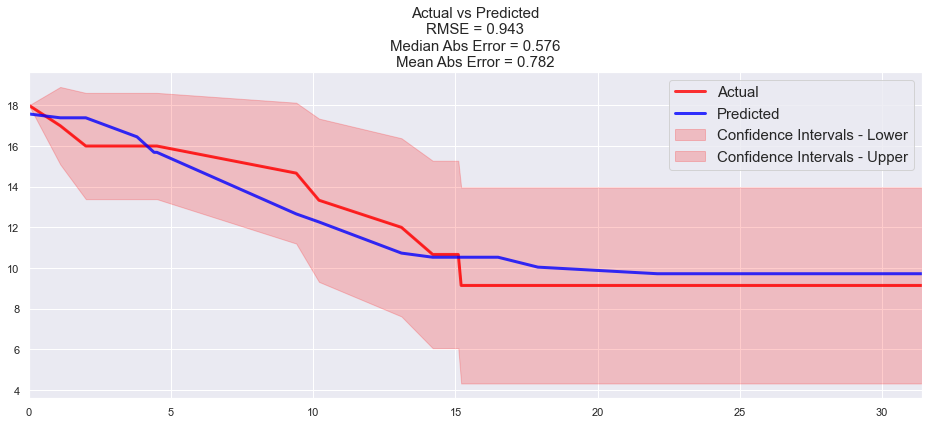

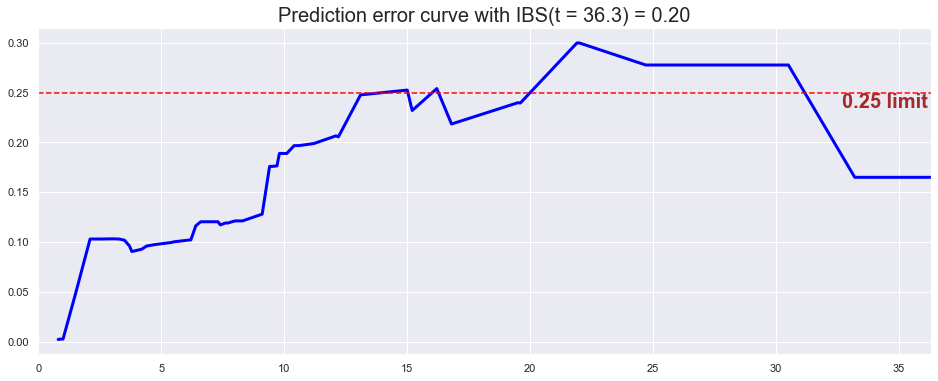

C-index: 0.64
IBS: 0.20

 2 of kfold 5


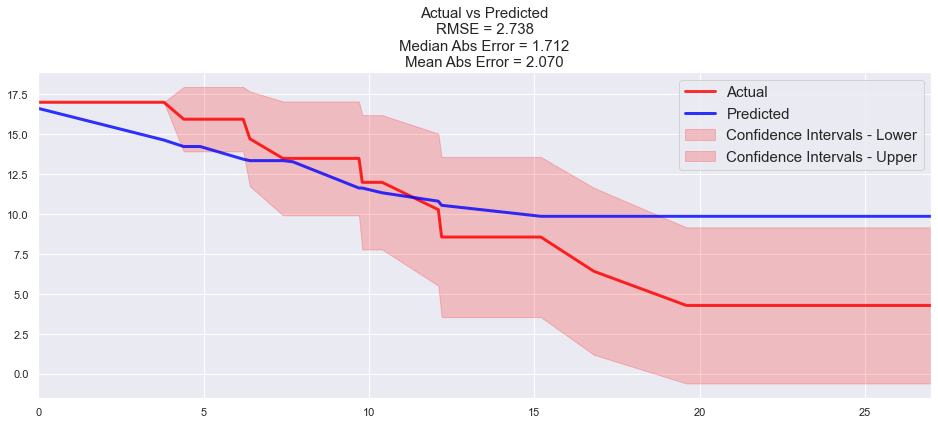

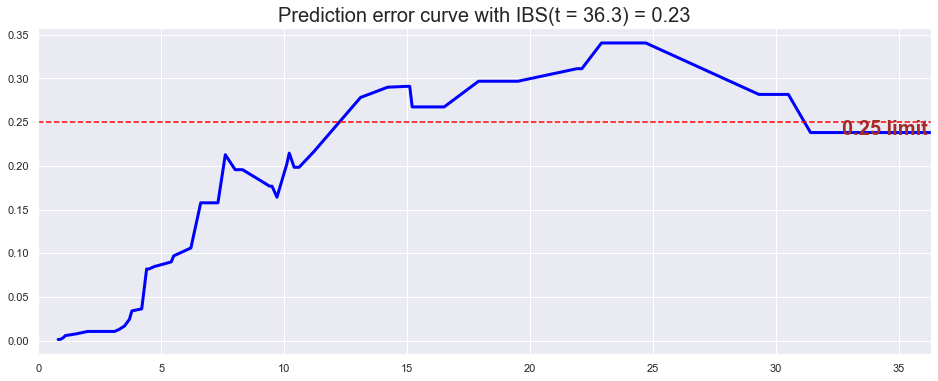

C-index: 0.51
IBS: 0.23

 3 of kfold 5


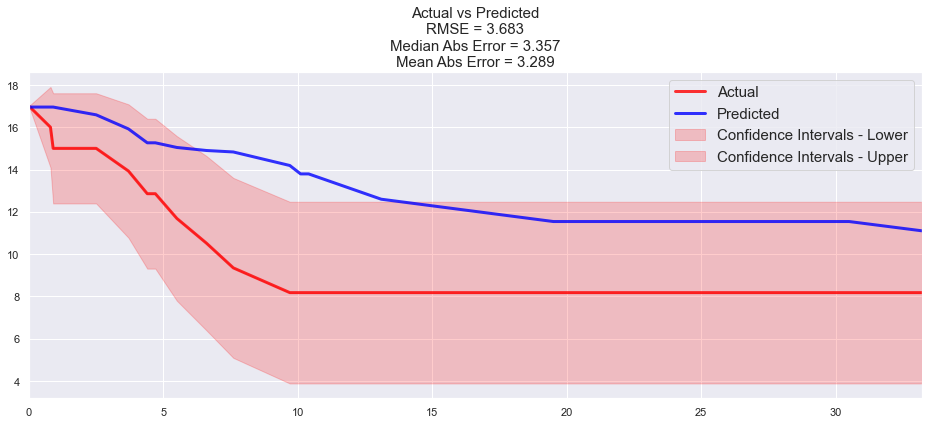

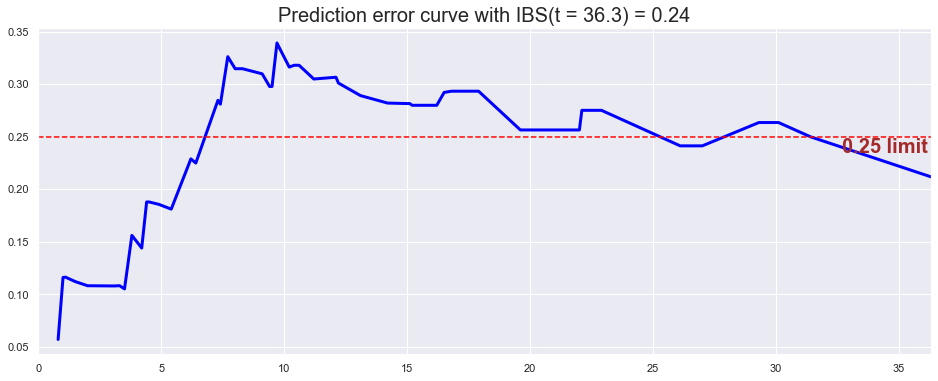

C-index: 0.71
IBS: 0.24

 4 of kfold 5


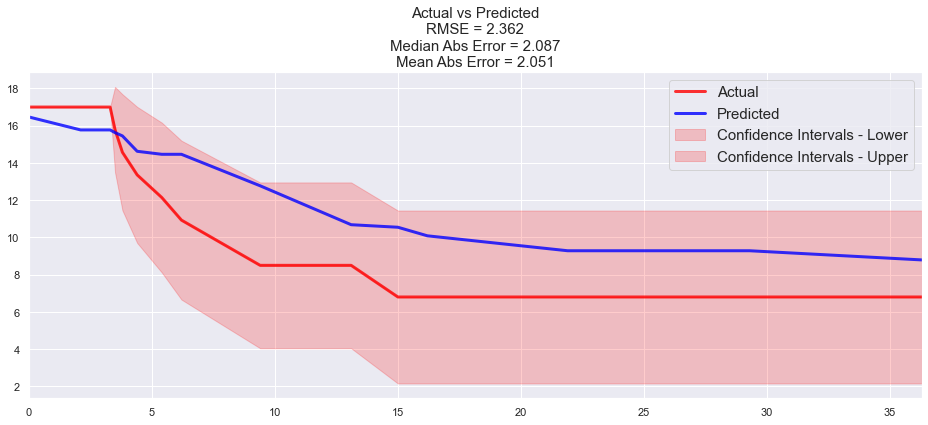

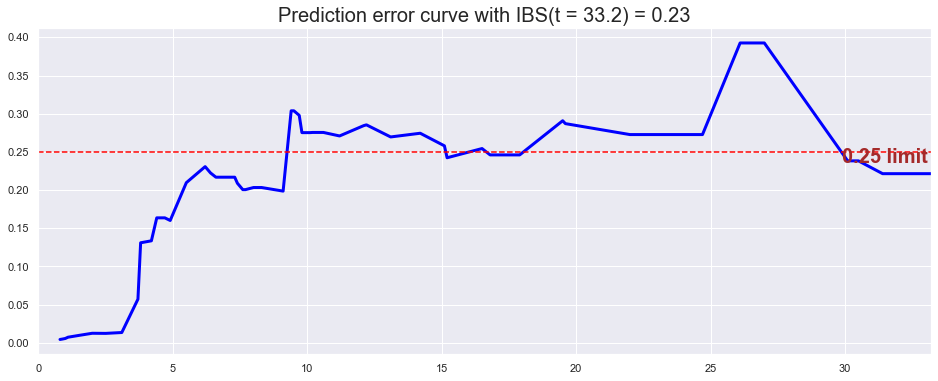

C-index: 0.66
IBS: 0.23

 5 of kfold 5


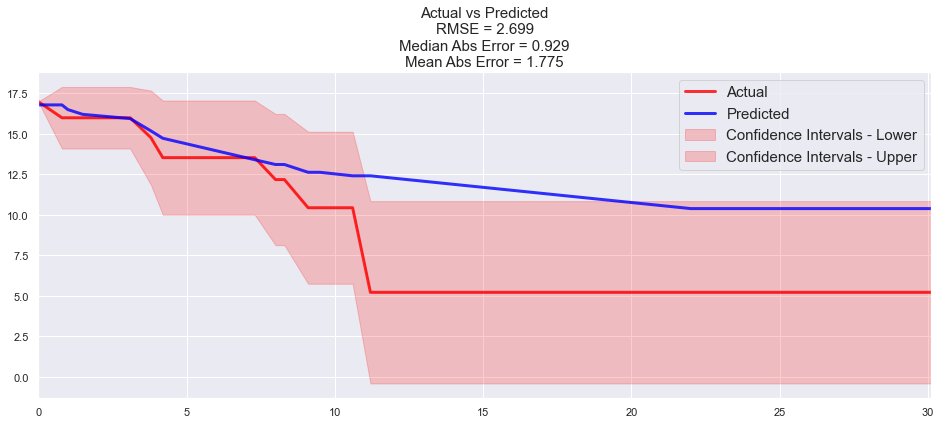

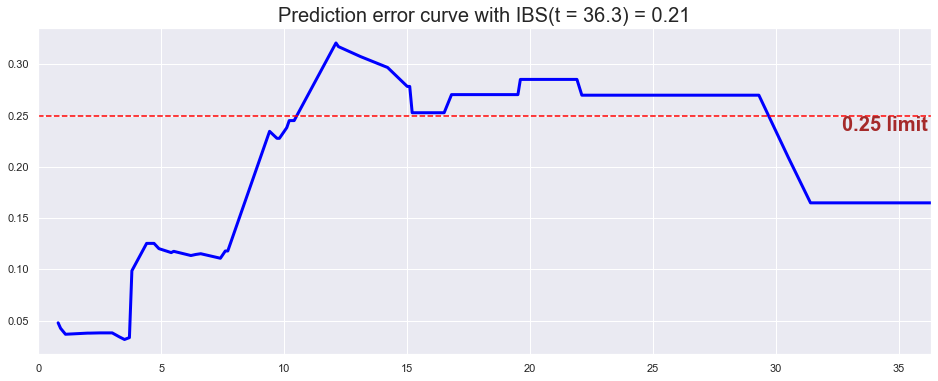

C-index: 0.73
IBS: 0.21

 

                 Data  Best Gridsearch CI    CI Avg    CI STD   IBS Avg  \
0  liver_plus_gtv.csv            0.778315  0.650012  0.084843  0.223372   

   IBS STD  Num Trees  Max Depth  Min Node  
0  0.01756         20          6         2  


In [12]:
results = []
data_name = 'liver_plus_gtv.csv'
processed_file_name = 'filtered_' + data_name 
if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
else:
    filtered_data = pd.read_csv(processed_file_name)
    print('Loading existing selected features...\n')
    
print('\n \n')


print('Running gridsearch on: ' + data_name + '\n')

gridsearch_file_name = 'gridsearch_' + data_name 
    
if(not(os.path.exists(gridsearch_file_name))):
    print('Computing gridsearch...\n')
    (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
    print((c_index_best, num_tree_best,max_depth_best, min_node_best))
else:
    gridsearch_df = pd.read_csv(gridsearch_file_name)

    c_index_best = gridsearch_df['Values'][0]
    num_tree_best = gridsearch_df['Values'][1]
    max_depth_best = gridsearch_df['Values'][2]
    min_node_best = gridsearch_df['Values'][3]

    #print(c_index_best)
    print('Loading existing gridsearch hyperparameters...\n')

# generating model form best gridsearch combination

print('Evaluating K-folds with best hyperparameter combination...\n')
(CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)

results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
print('\n \n')
results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

print(results_DF)

### Main script starts here

In [21]:
# Loading all the data
# Single run of all datasets below, separate single-use code at bottom

#outcome as local progression
gtv = 'gtv.csv'
liver_sub_gtv = 'liver_sub_gtv.csv'
liver_plus_gtv = 'liver_plus_gtv.csv'
gtv0 = 'gtv_0.csv'

#gtv_clin_variables = 'gtv_clin_variables.csv'
#liver_sub_gtv_clin_variables = 'liver_sub_gtv_clin_variables.csv'
#liver_plus_gtv_clin_variables = 'liver_plus_gtv_clin_variables.csv'
#gtv0_clin_variables = 'gtv_0_clin_variables.csv'

#outcome defined as any hepatic progression
gtv_hp = 'gtv_hp.csv'
liver_sub_gtv_hp = 'liver_sub_gtv_hp.csv'
liver_plus_gtv_hp = 'liver_plus_gtv_hp.csv'
gtv0_hp = 'gtv_0_hp.csv'

#looking at only subsets of clinical variables
clin_variables = 'clin_variables_fflp.csv'
clin_variables_imaging = 'clin_variables_imaging_fflp.csv'
clin_variables_non_imaging = 'clin_variables_non_imaging_fflp.csv'

#any hepatic progression
clin_variables_hp = 'clin_variables_hp.csv'
clin_variables_imaging_hp = 'clin_variables_imaging_hp.csv'
clin_variables_non_imaging_hp = 'clin_variables_non_imaging_hp.csv'

data_list = list()
data_list.extend((gtv, liver_sub_gtv, liver_plus_gtv, gtv0, gtv_hp, liver_sub_gtv_hp, liver_plus_gtv_hp, gtv0_hp,
                 clin_variables, clin_variables_imaging, clin_variables_non_imaging,
                 clin_variables_hp, clin_variables_imaging_hp, clin_variables_non_imaging_hp))

In [14]:
# file integrity test
for data_name in data_list:
    test  = pd.read_csv(data_name)

Processing: gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


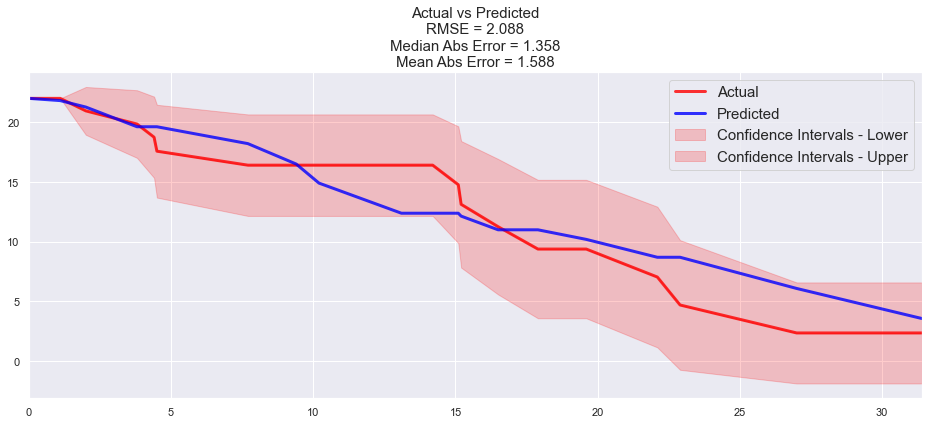

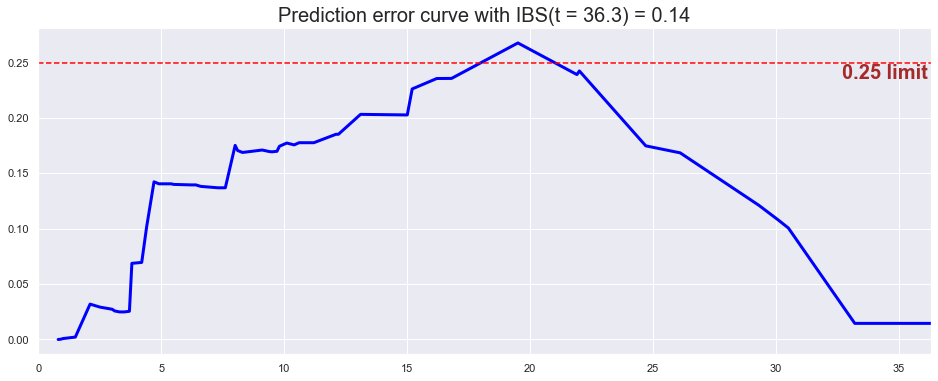

C-index: 0.60
IBS: 0.14

 2 of kfold 4


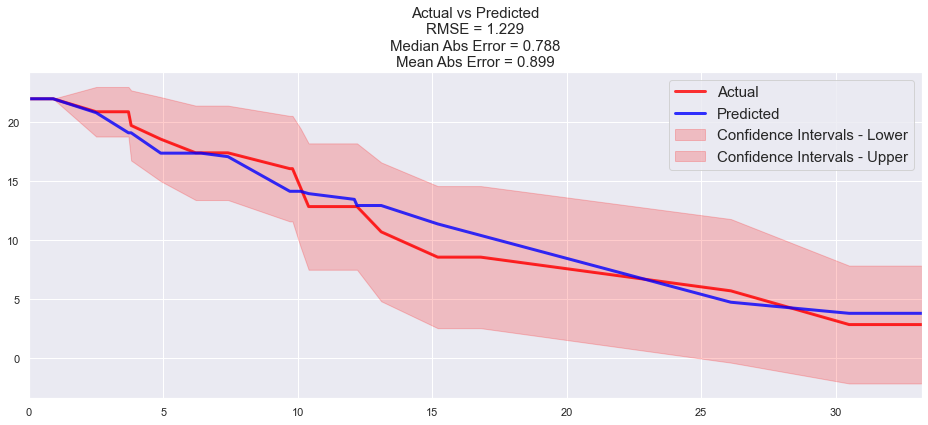

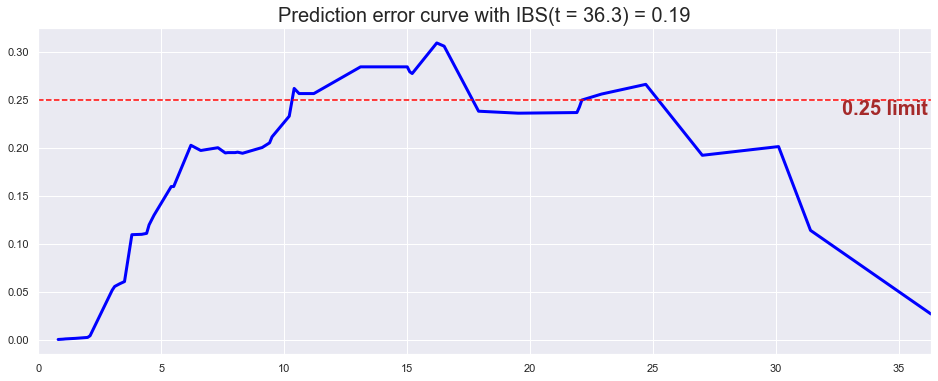

C-index: 0.55
IBS: 0.19

 3 of kfold 4


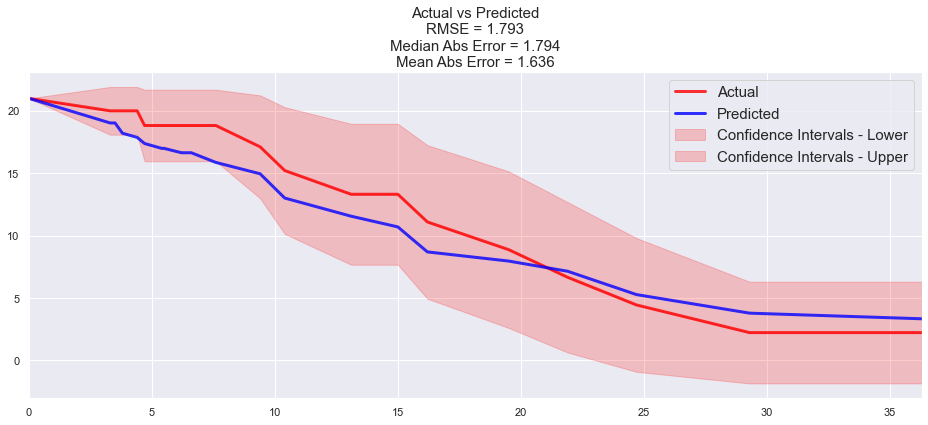

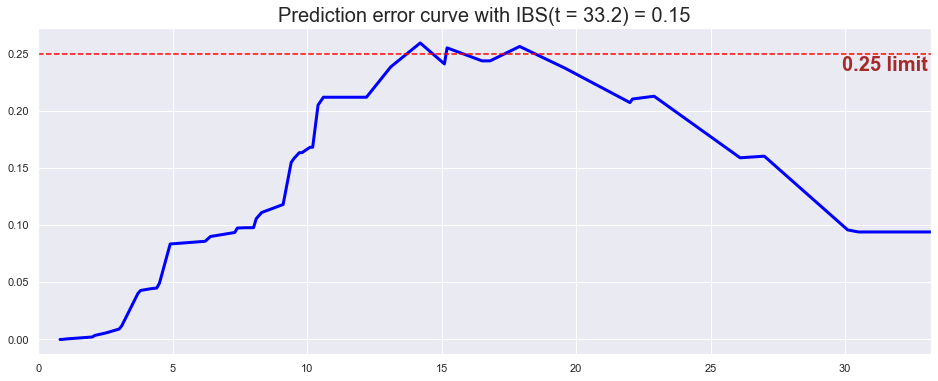

C-index: 0.61
IBS: 0.15

 4 of kfold 4


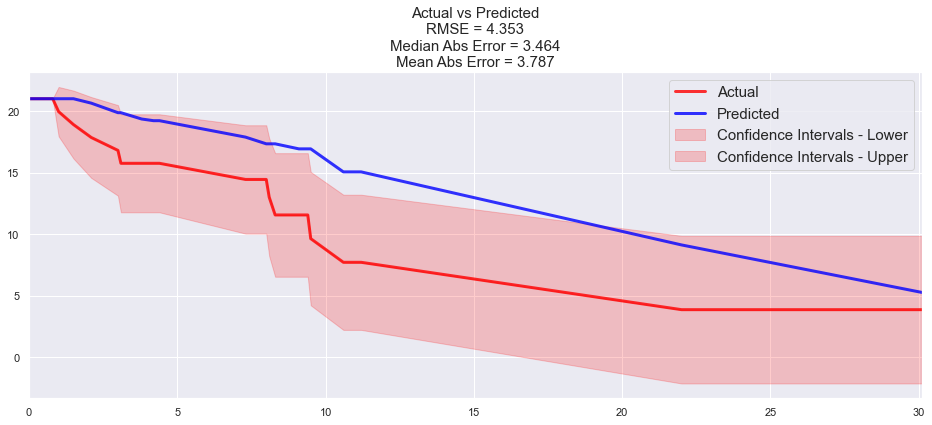

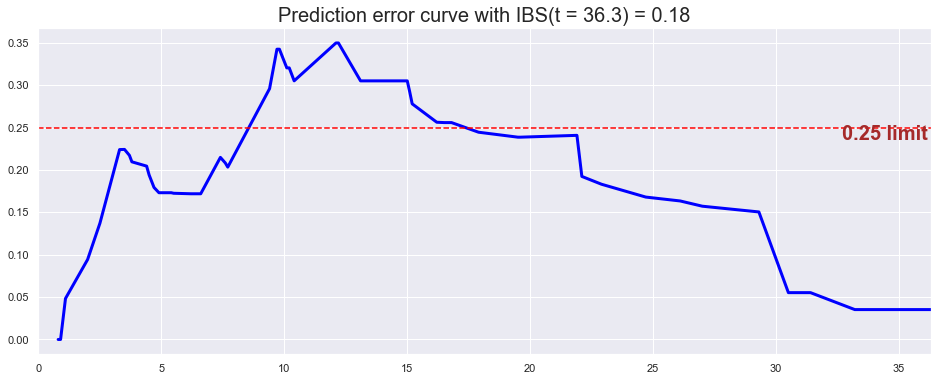

C-index: 0.69
IBS: 0.18

 

Processing: liver_sub_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


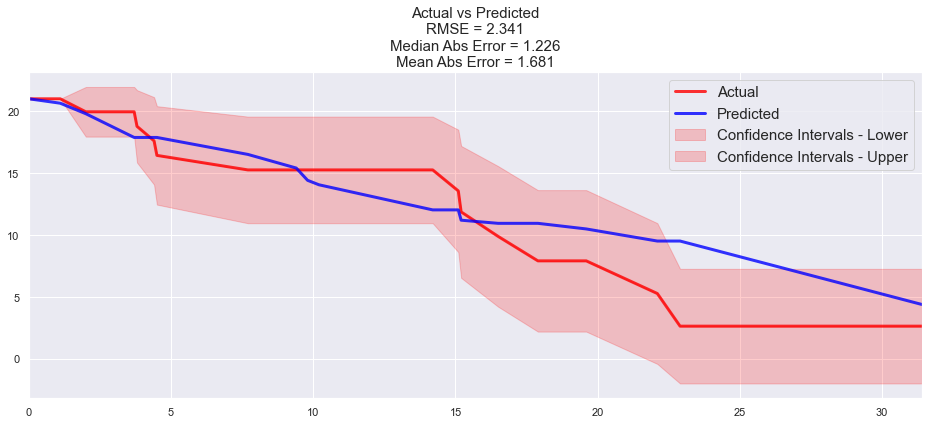

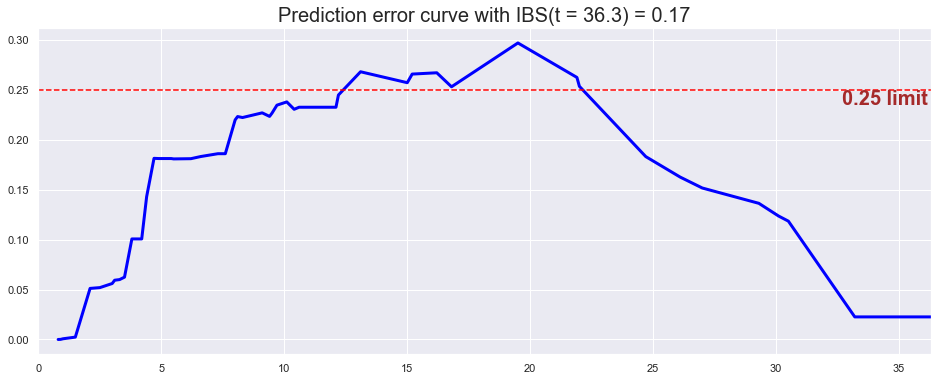

C-index: 0.72
IBS: 0.17

 2 of kfold 4


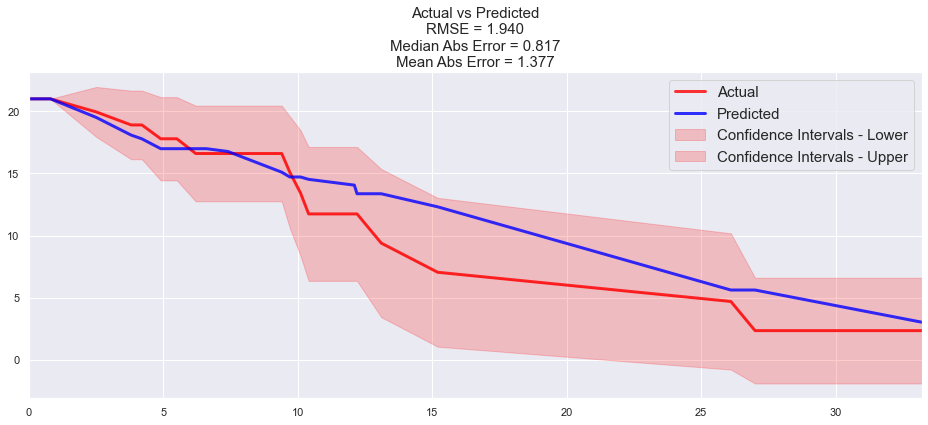

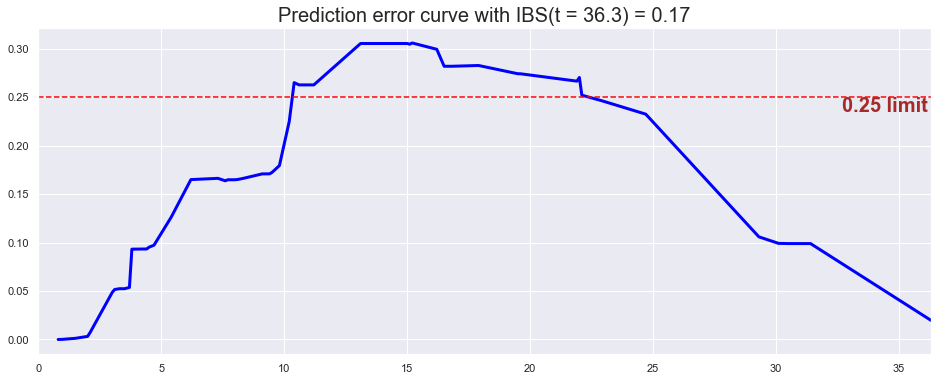

C-index: 0.55
IBS: 0.17

 3 of kfold 4


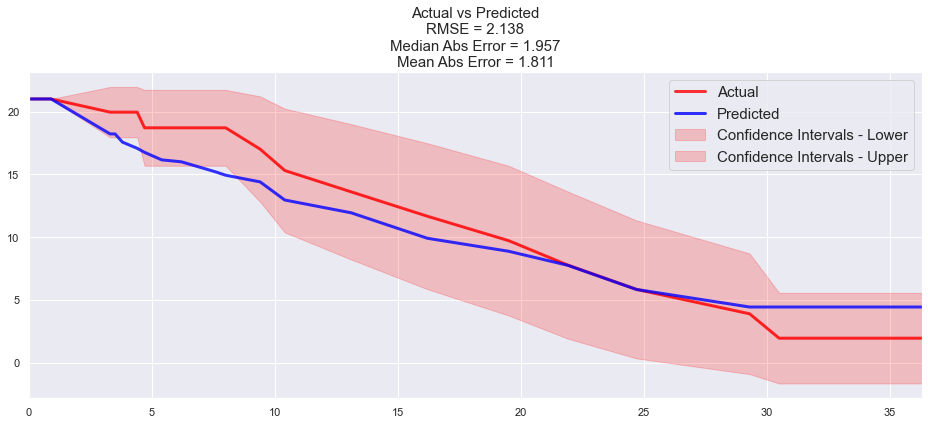

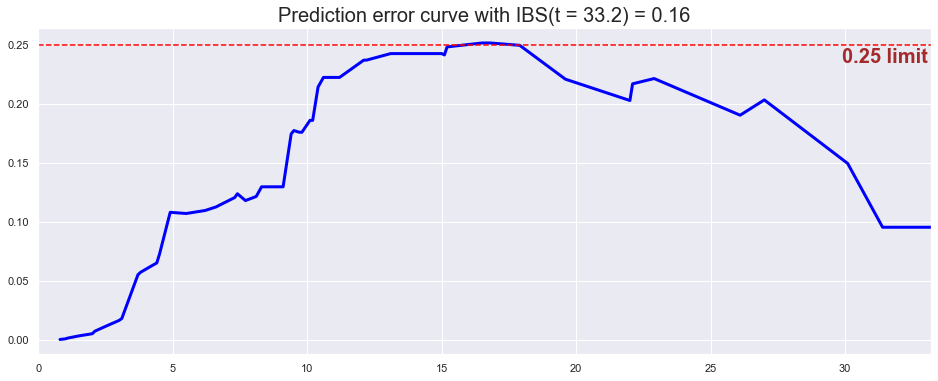

C-index: 0.59
IBS: 0.16

 4 of kfold 4


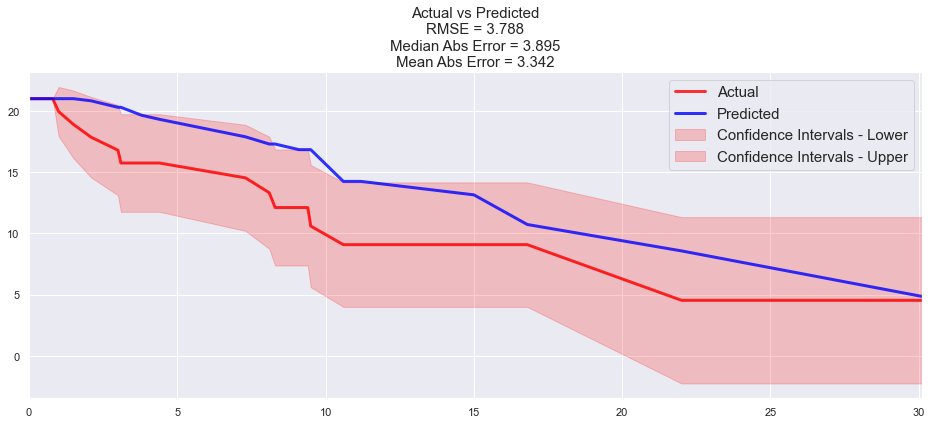

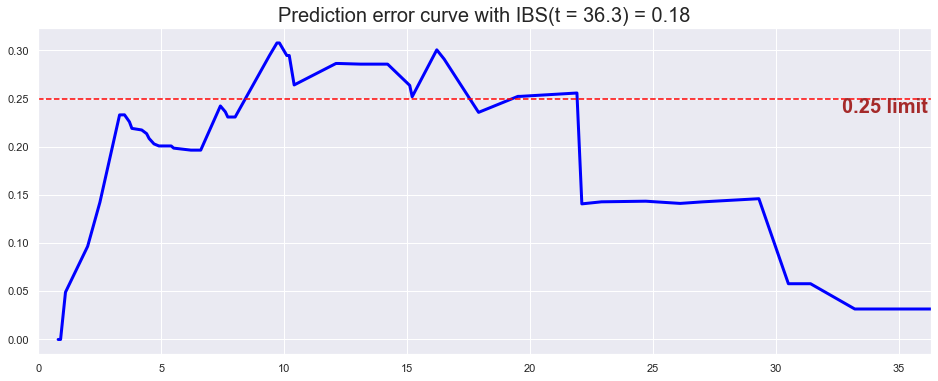

C-index: 0.60
IBS: 0.18

 

Processing: liver_plus_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


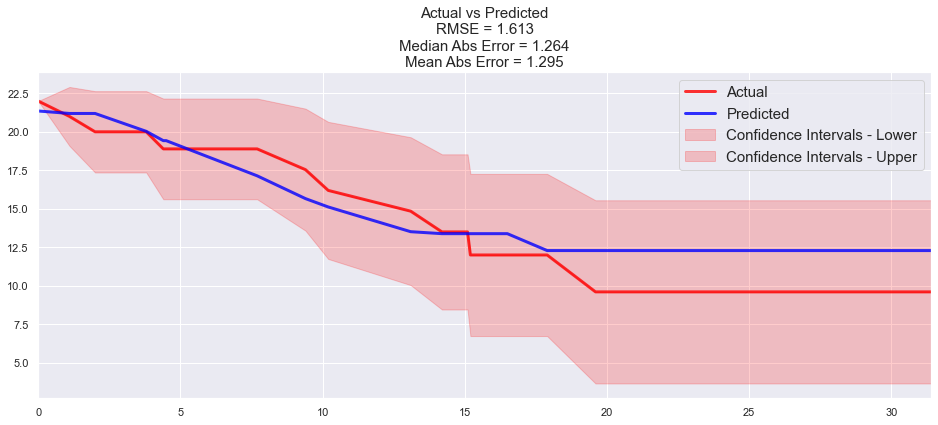

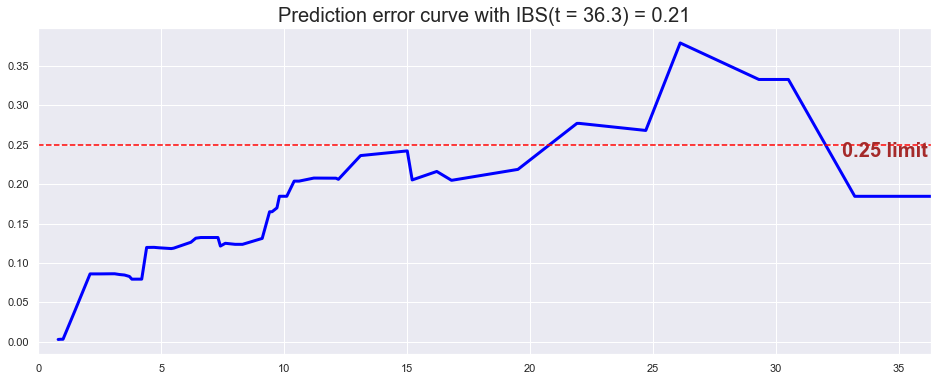

C-index: 0.70
IBS: 0.21

 2 of kfold 4


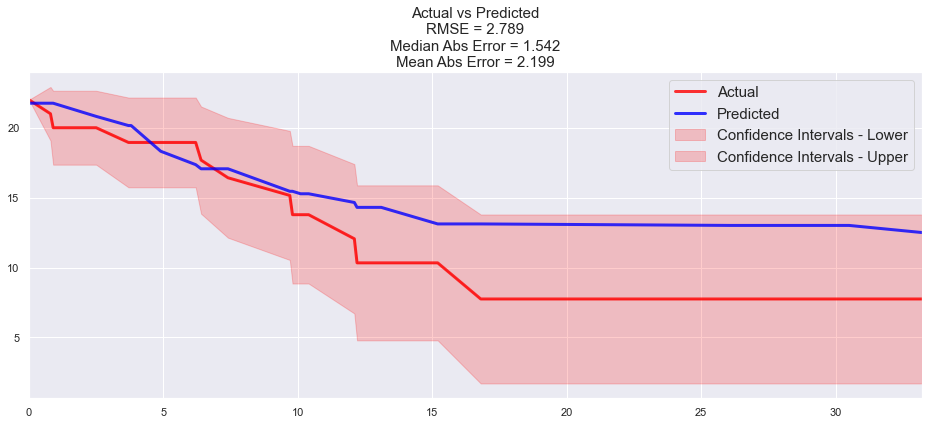

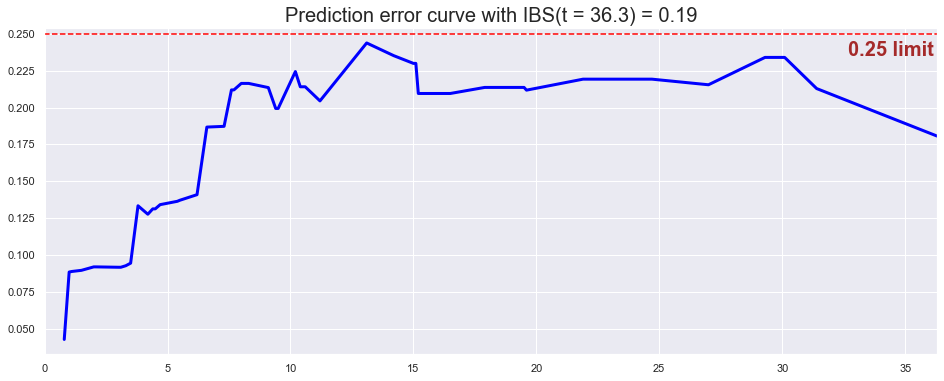

C-index: 0.70
IBS: 0.19

 3 of kfold 4


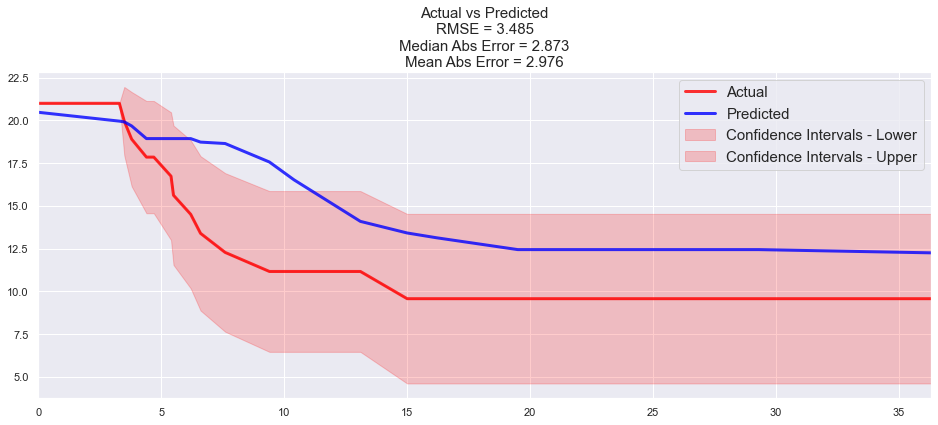

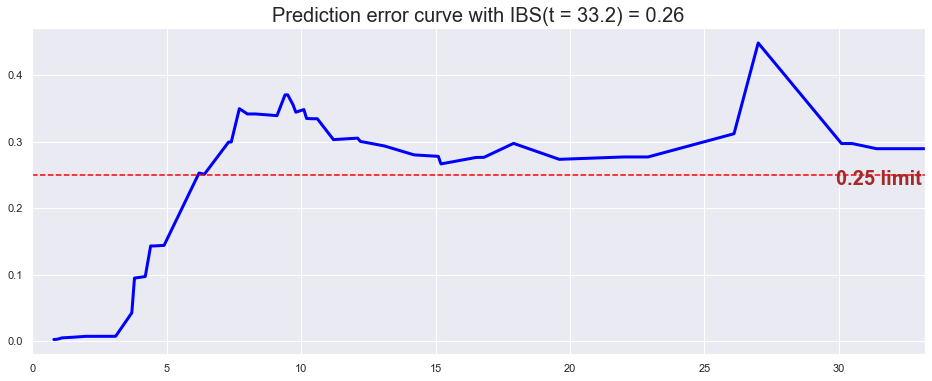

C-index: 0.55
IBS: 0.26

 4 of kfold 4


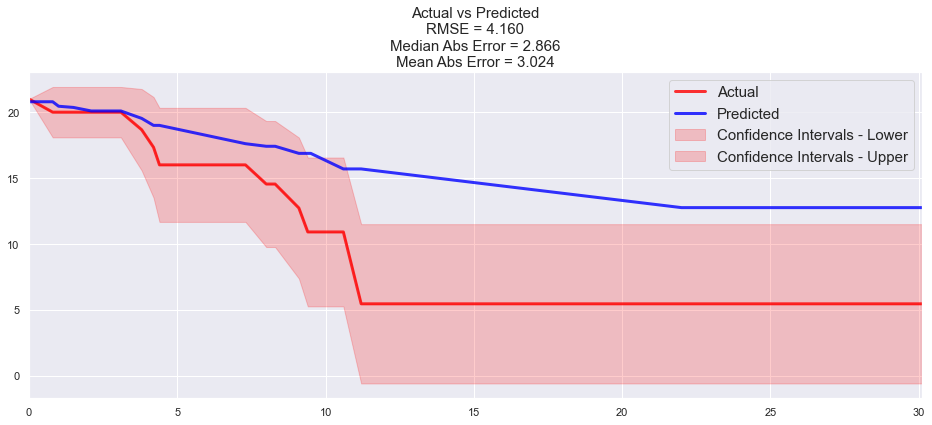

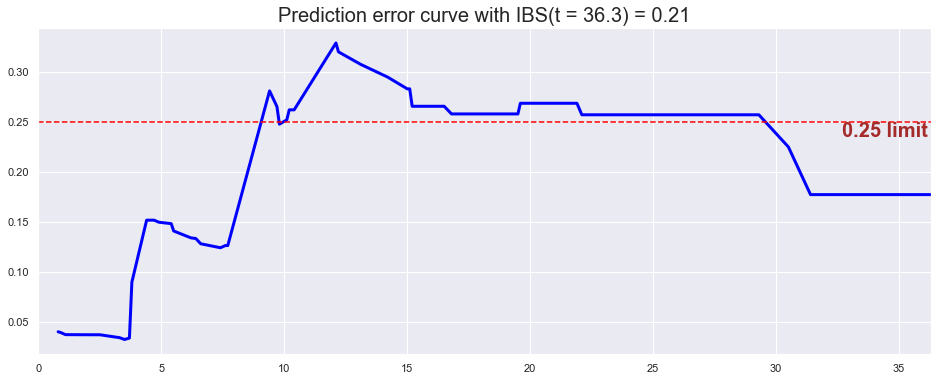

C-index: 0.82
IBS: 0.21

 

Processing: gtv_0.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_0.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


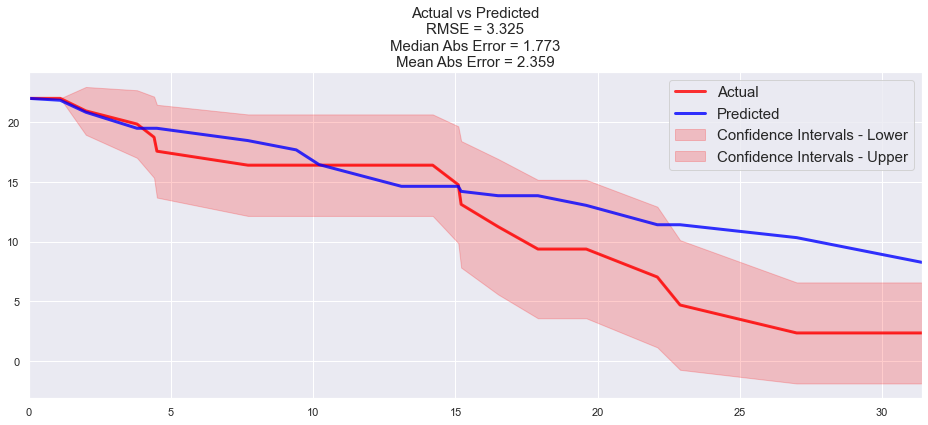

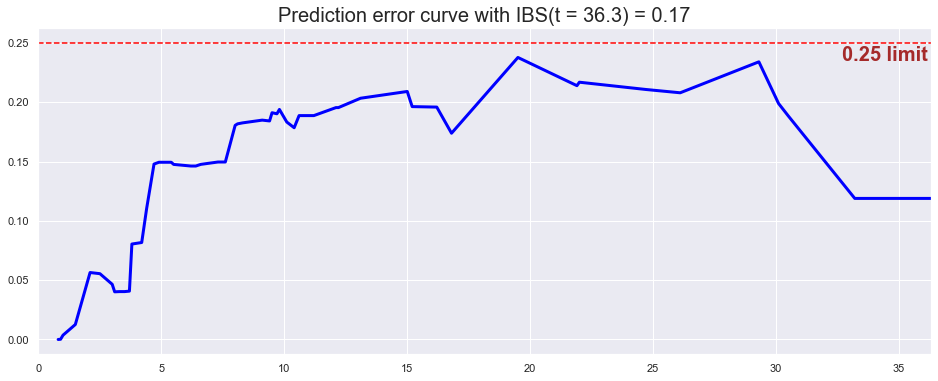

C-index: 0.64
IBS: 0.17

 2 of kfold 4


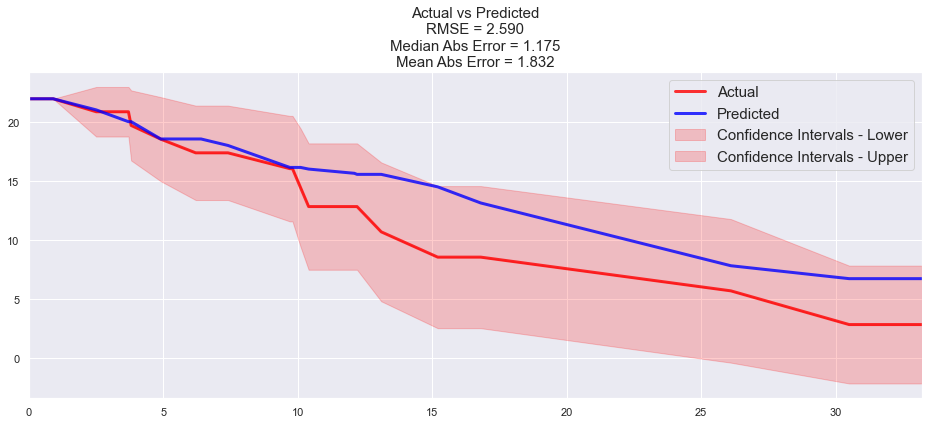

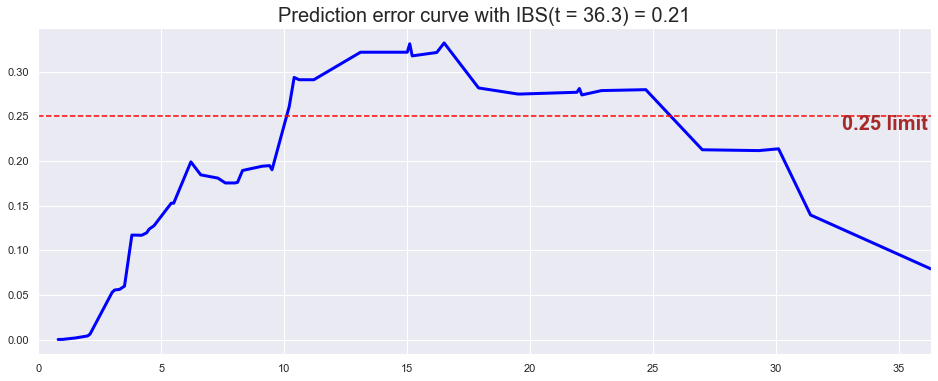

C-index: 0.52
IBS: 0.21

 3 of kfold 4


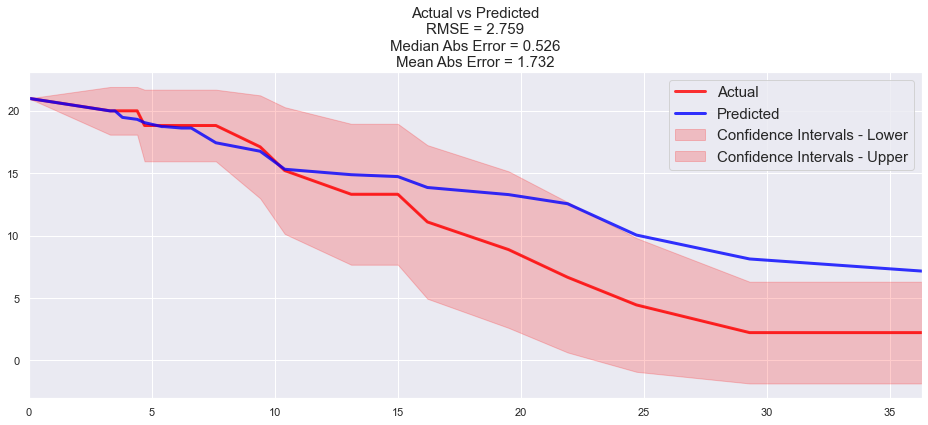

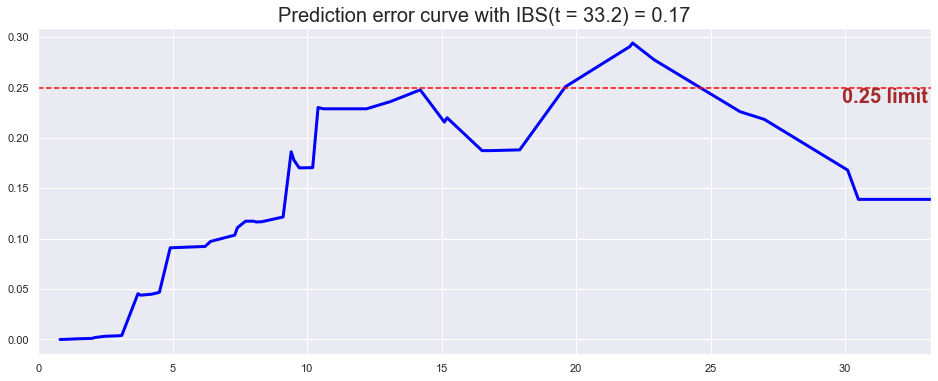

C-index: 0.58
IBS: 0.17

 4 of kfold 4


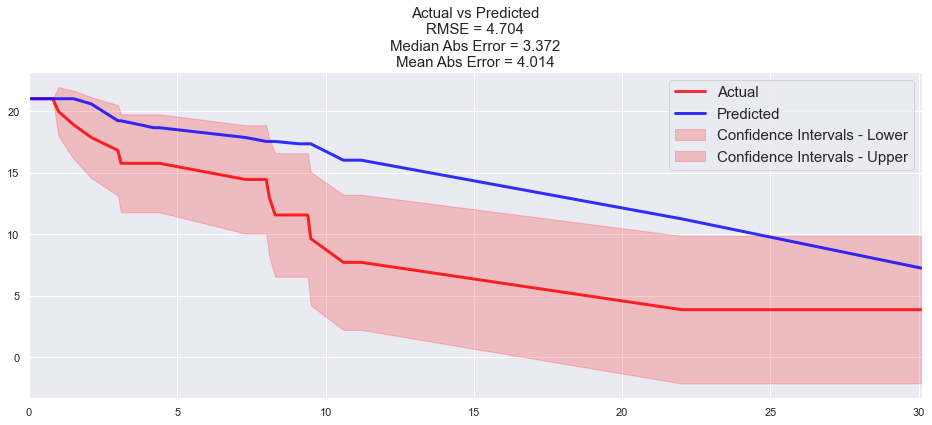

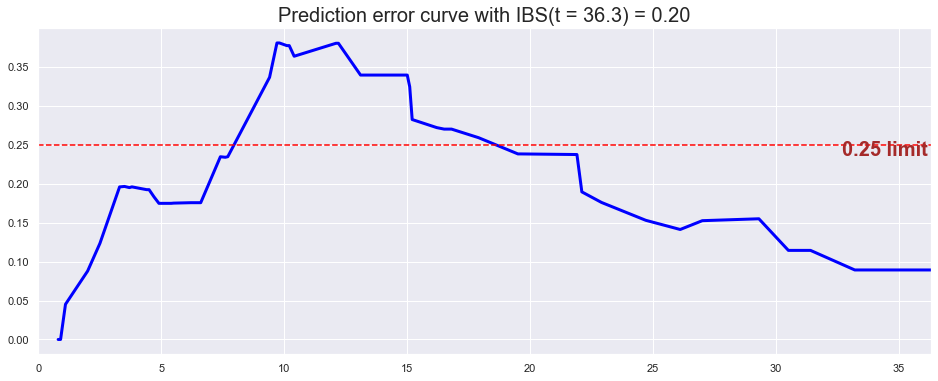

C-index: 0.62
IBS: 0.20

 

Processing: gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


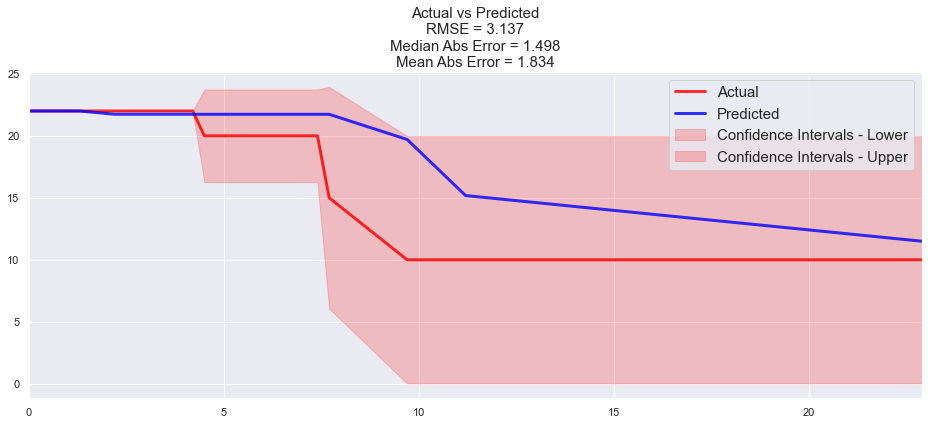

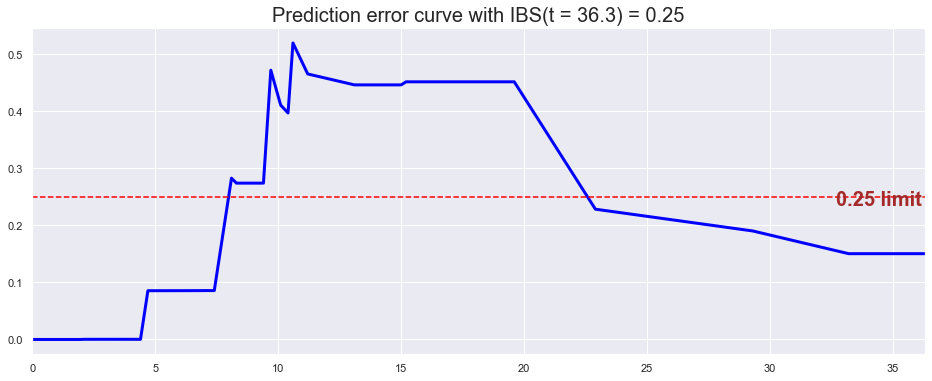

C-index: 0.63
IBS: 0.25

 2 of kfold 4


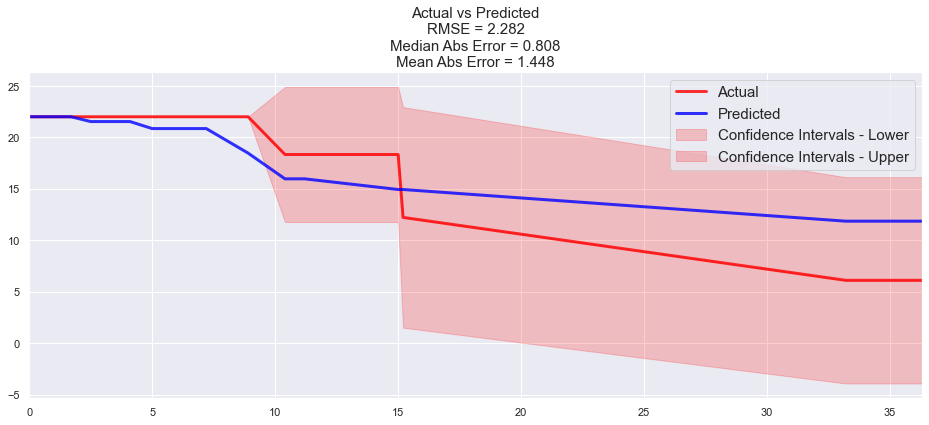

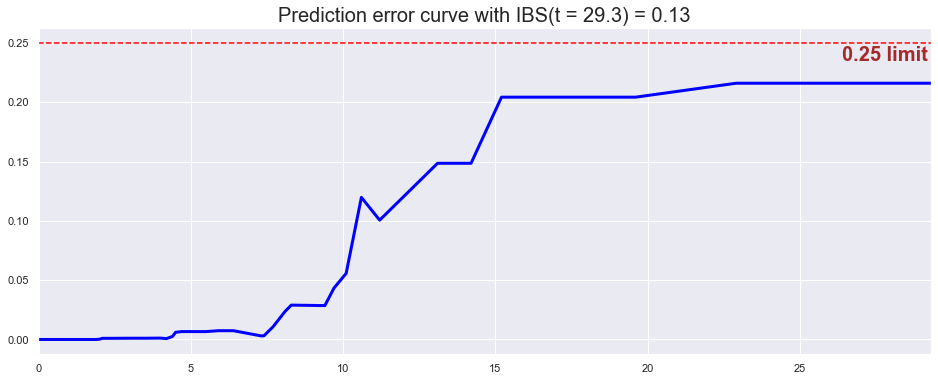

C-index: 0.92
IBS: 0.13

 3 of kfold 4


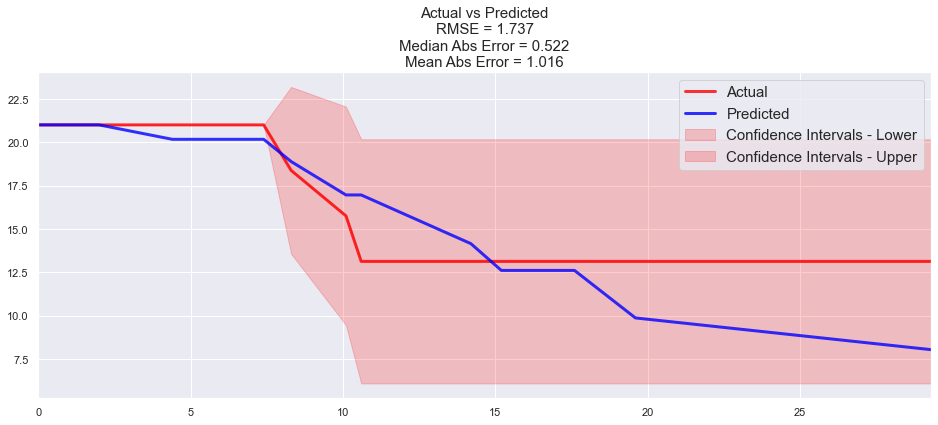

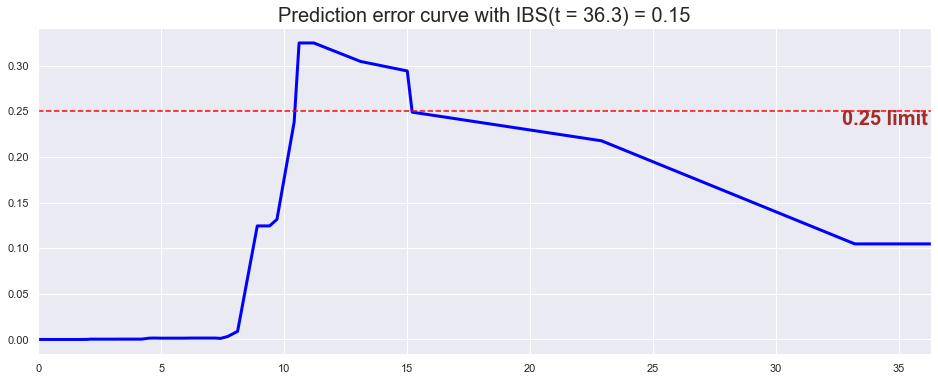

C-index: 0.72
IBS: 0.15

 4 of kfold 4


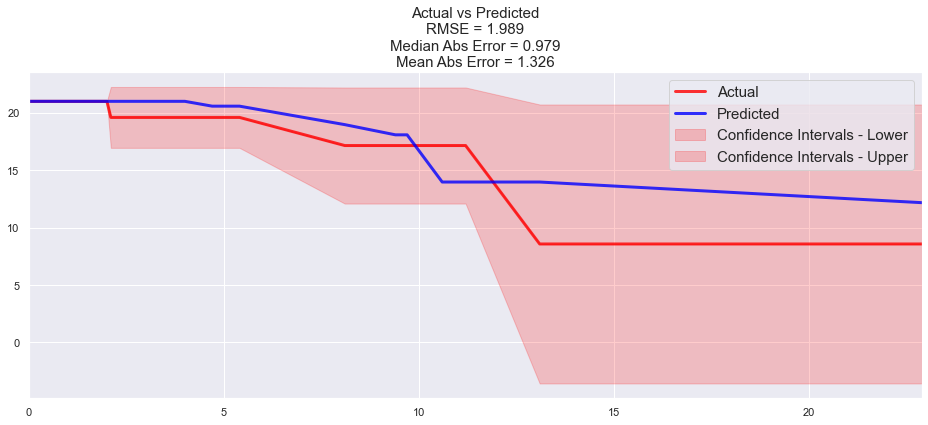

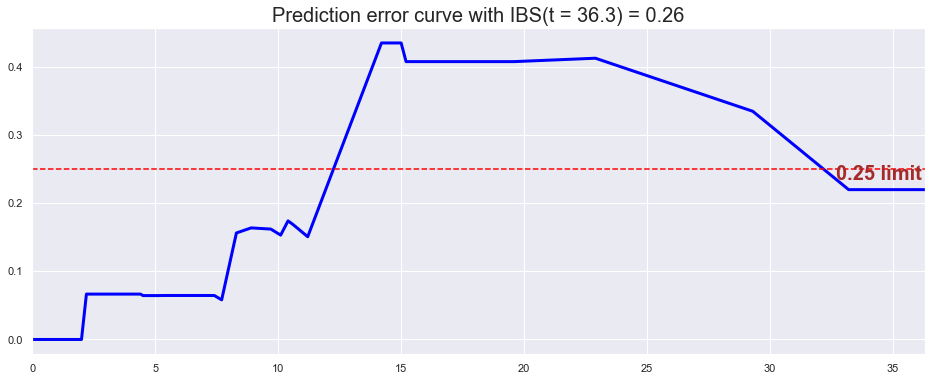

C-index: 0.70
IBS: 0.26

 

Processing: liver_sub_gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


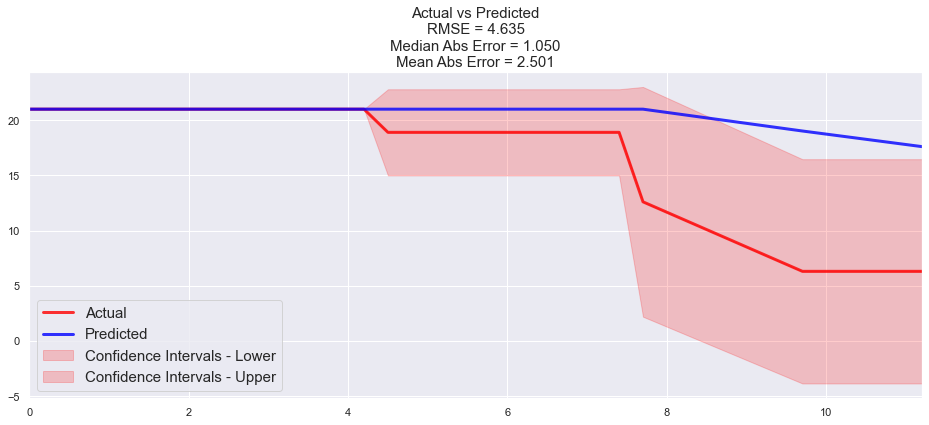

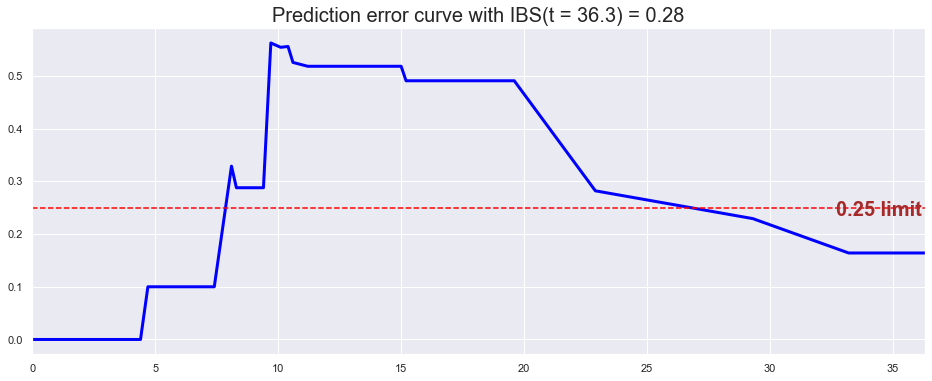

C-index: 0.50
IBS: 0.28

 2 of kfold 4


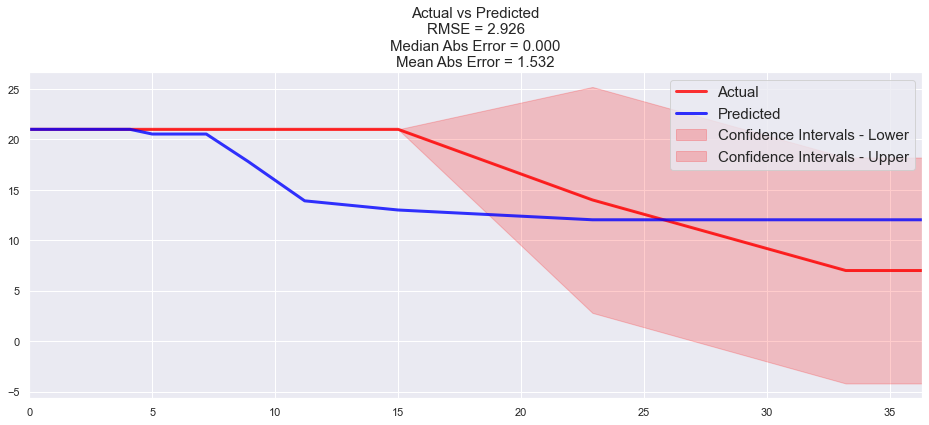

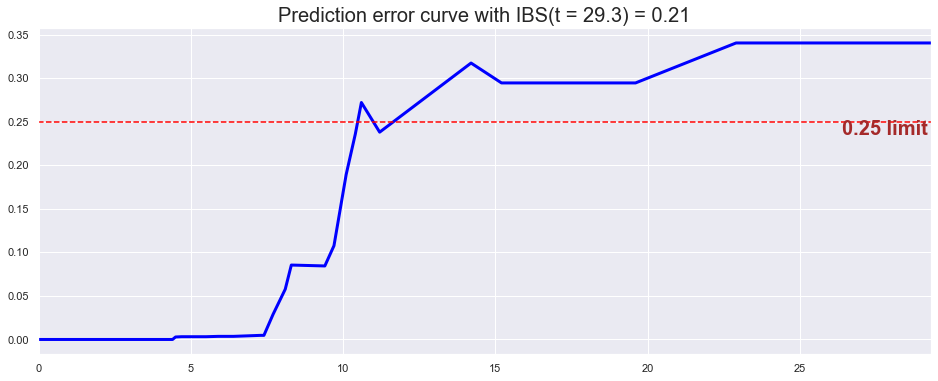

C-index: 0.67
IBS: 0.21

 3 of kfold 4


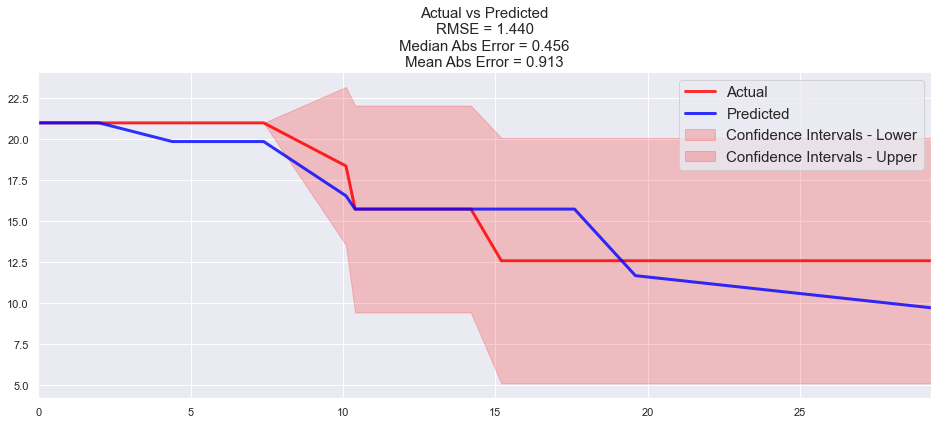

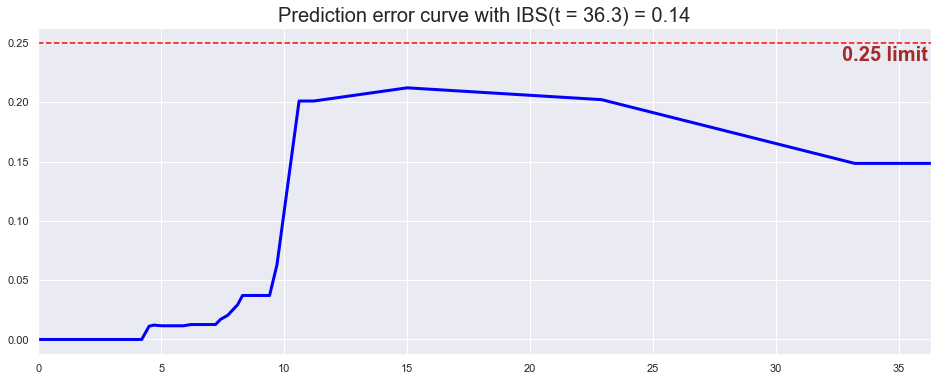

C-index: 0.51
IBS: 0.14

 4 of kfold 4


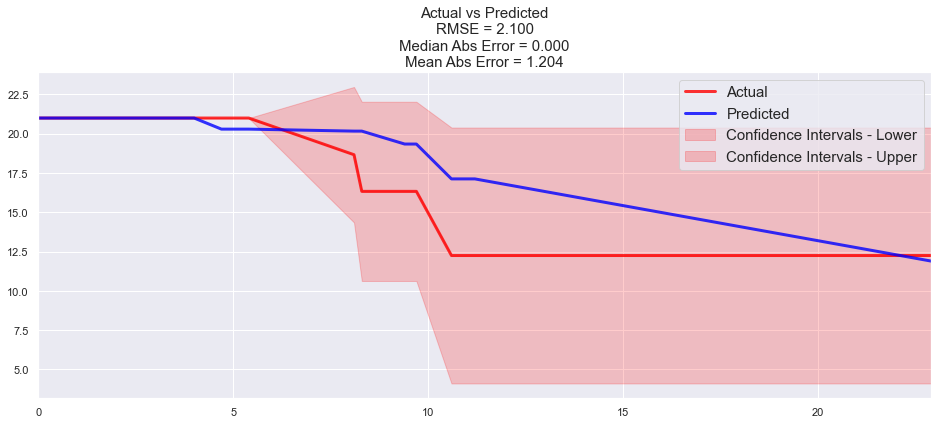

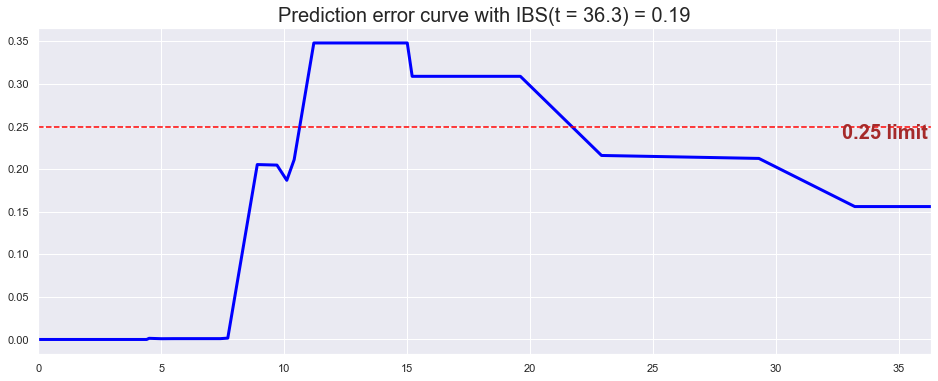

C-index: 0.52
IBS: 0.19

 

Processing: liver_plus_gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


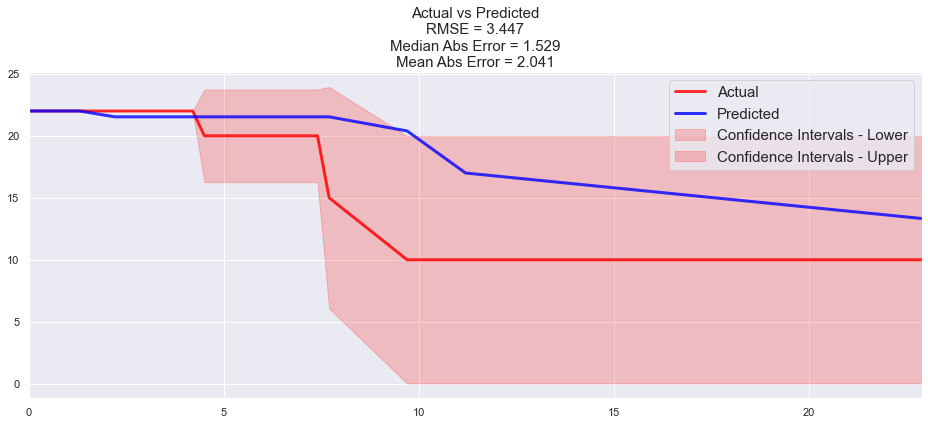

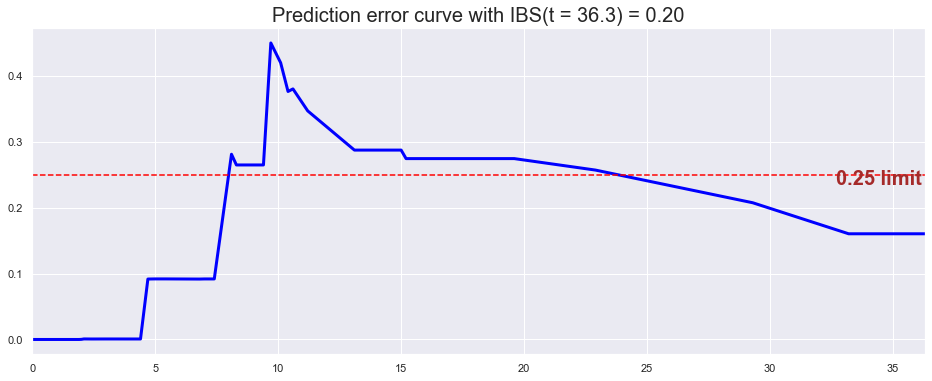

C-index: 0.78
IBS: 0.20

 2 of kfold 4


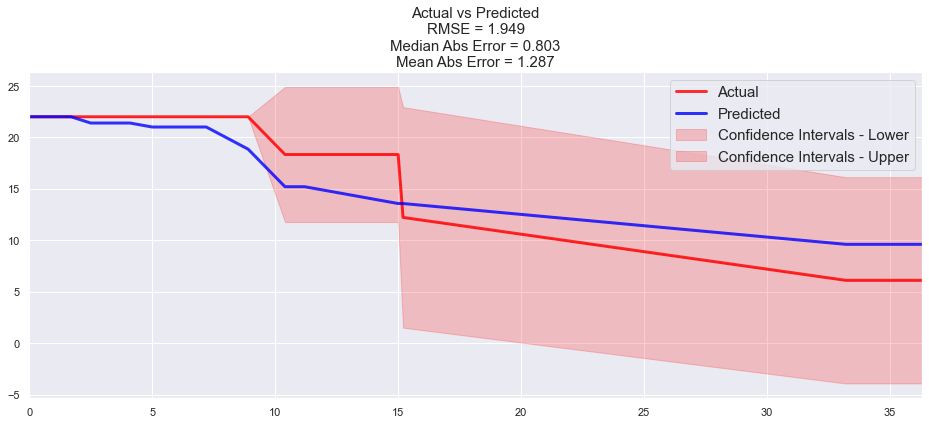

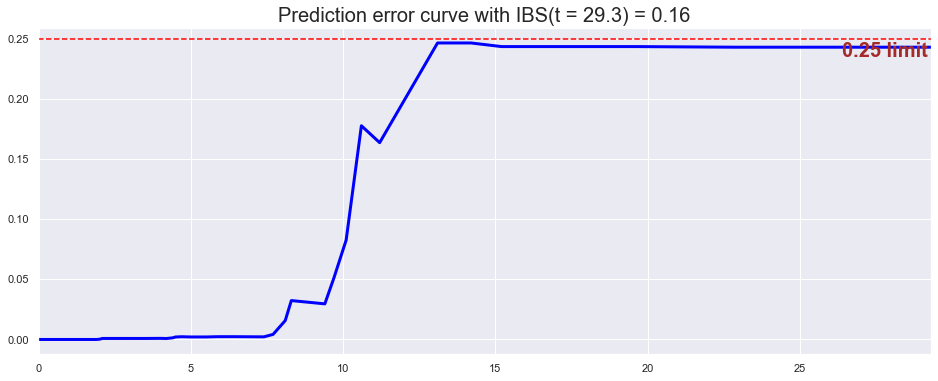

C-index: 0.85
IBS: 0.16

 3 of kfold 4


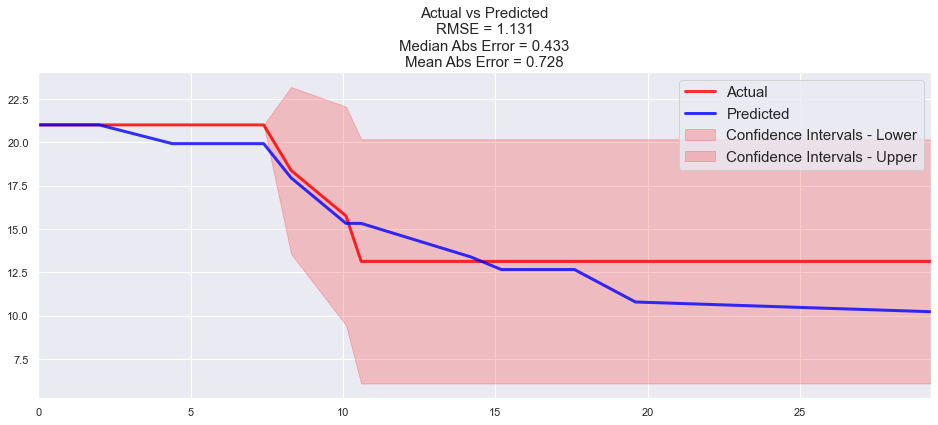

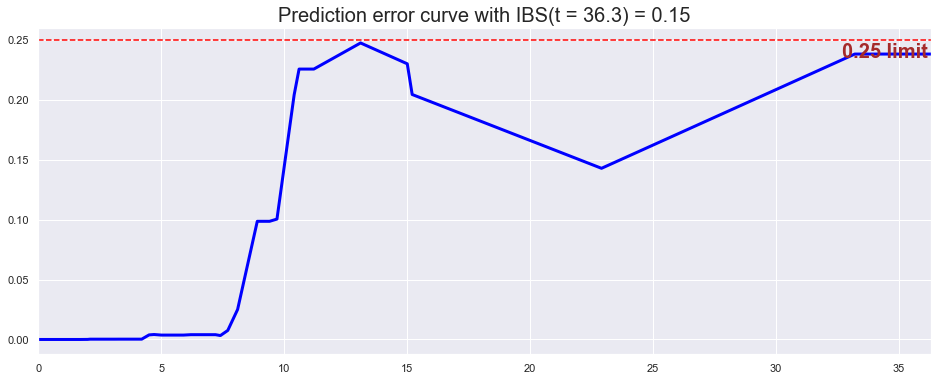

C-index: 0.58
IBS: 0.15

 4 of kfold 4


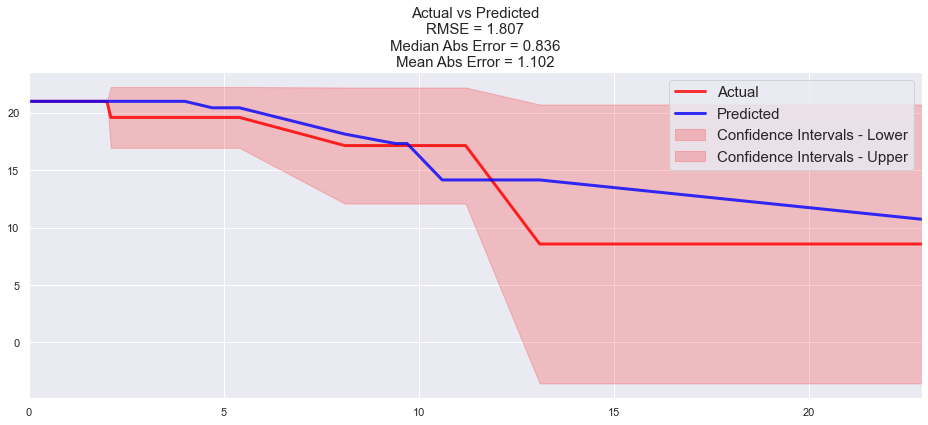

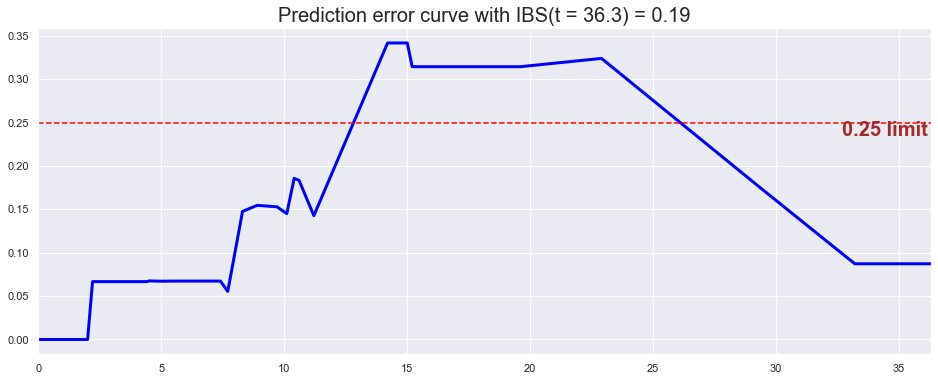

C-index: 0.77
IBS: 0.19

 

Processing: gtv_0_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_0_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


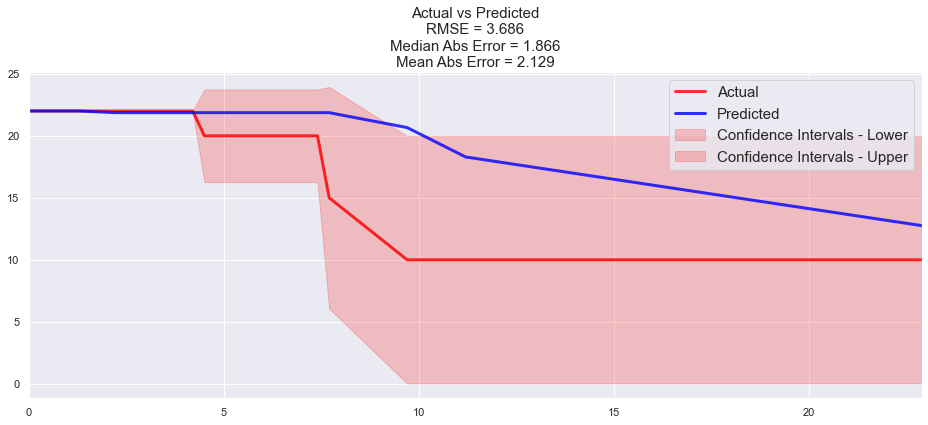

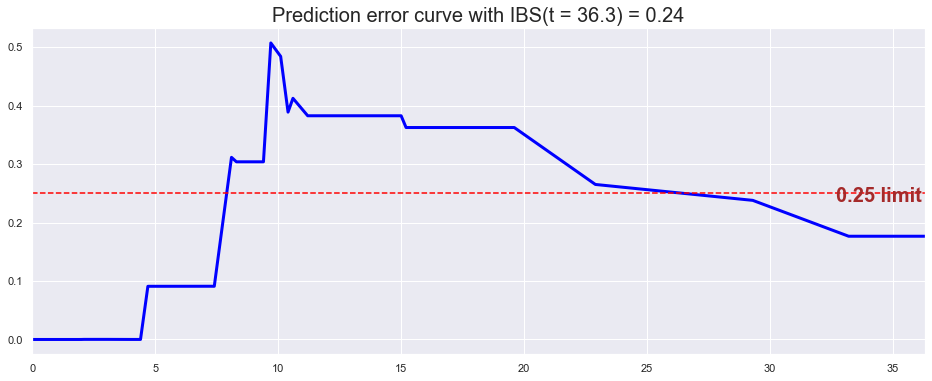

C-index: 0.63
IBS: 0.24

 2 of kfold 4


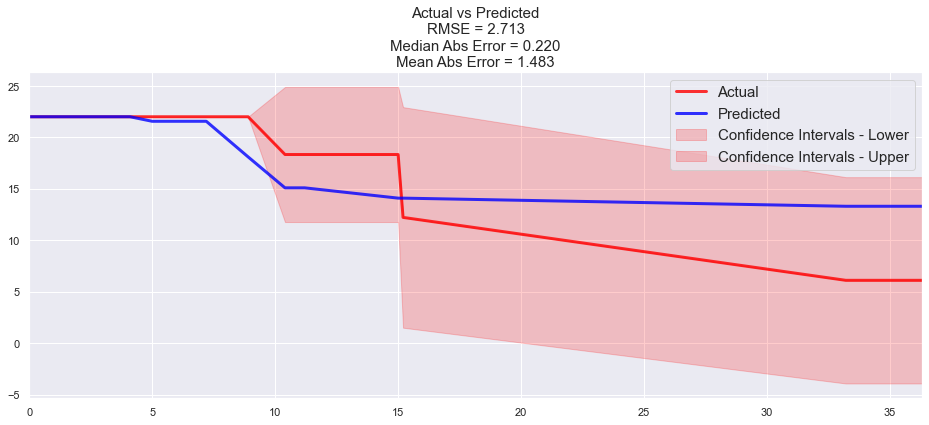

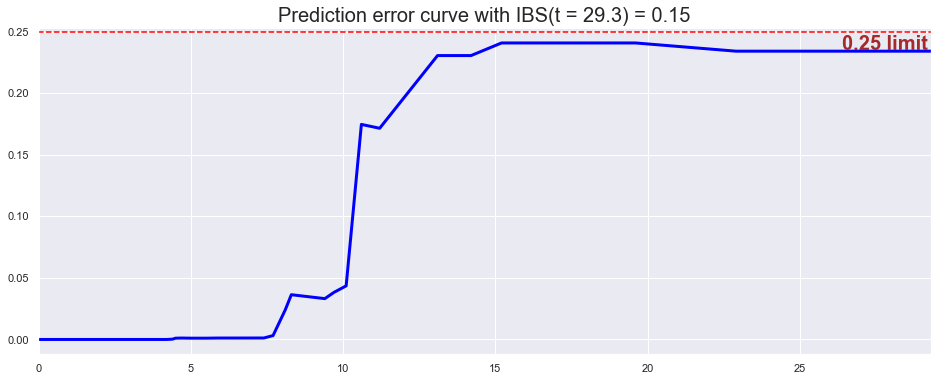

C-index: 0.51
IBS: 0.15

 3 of kfold 4


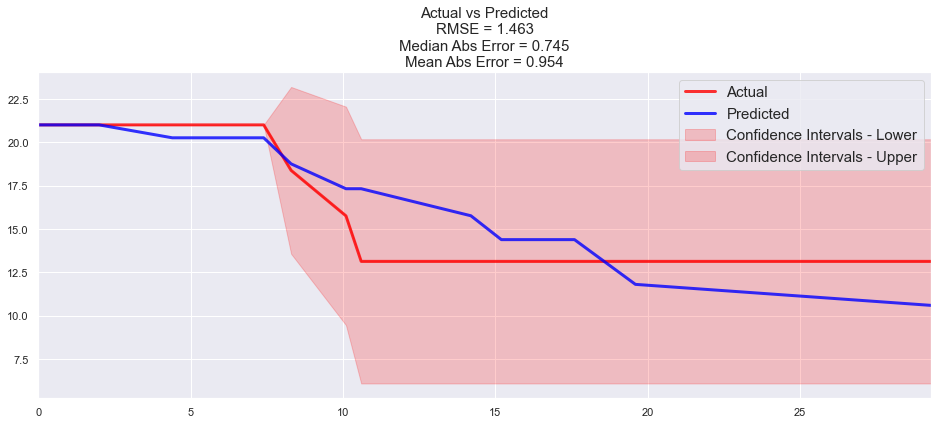

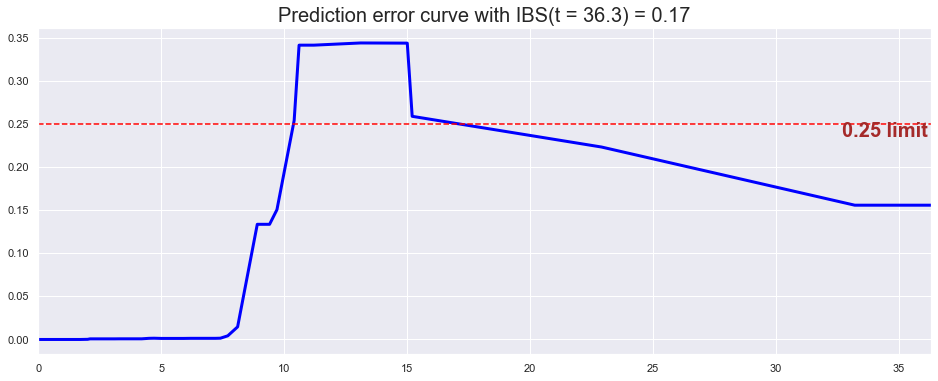

C-index: 0.78
IBS: 0.17

 4 of kfold 4


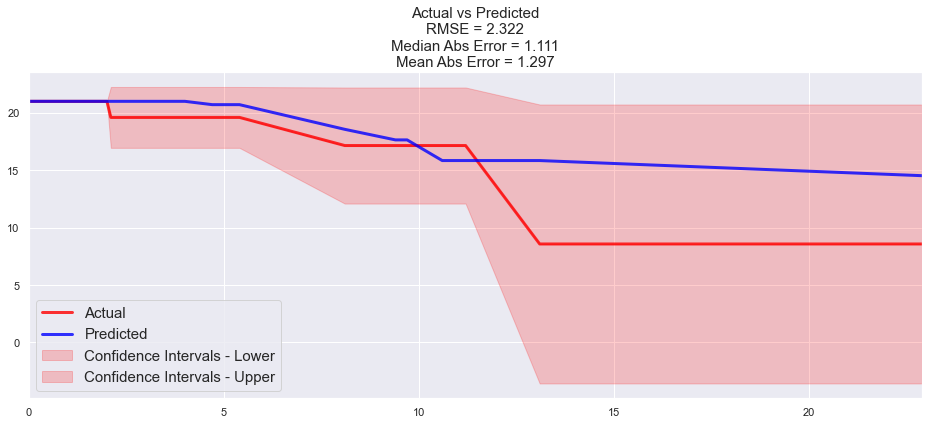

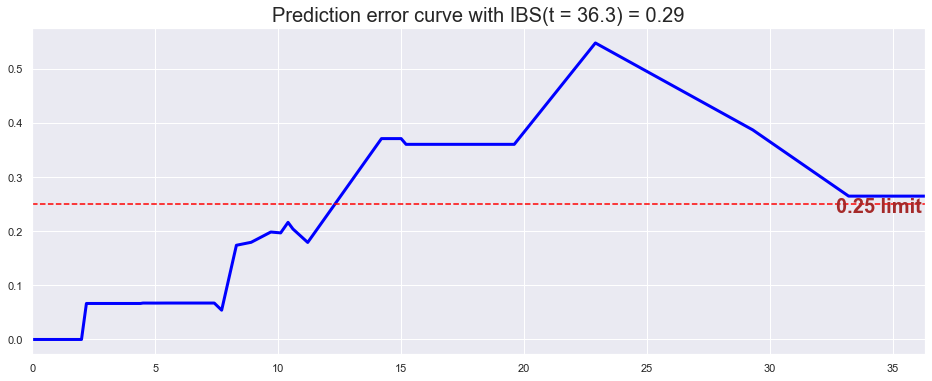

C-index: 0.62
IBS: 0.29

 

Processing: clin_variables_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


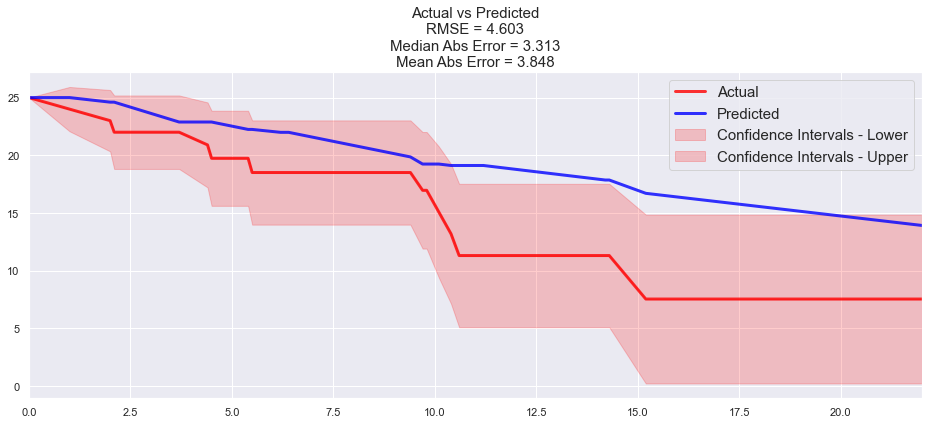

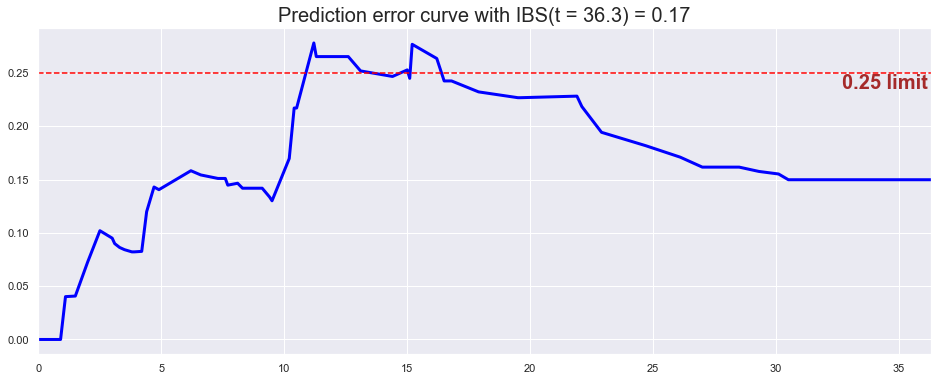

C-index: 0.79
IBS: 0.17

 2 of kfold 4


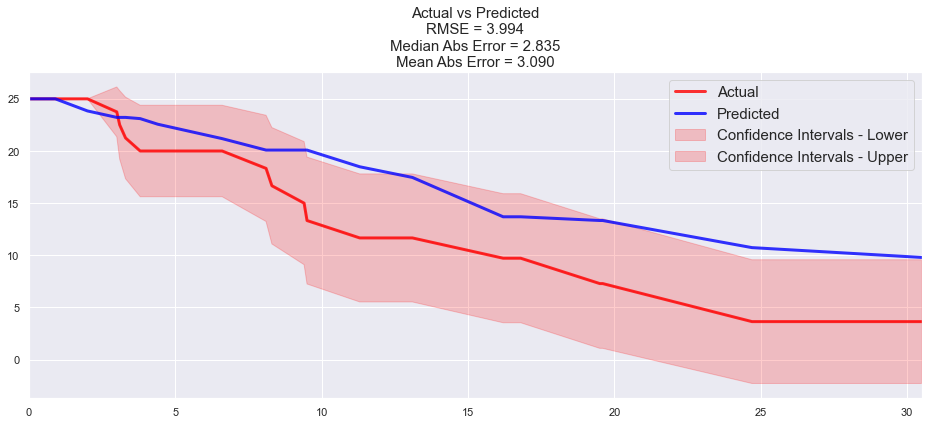

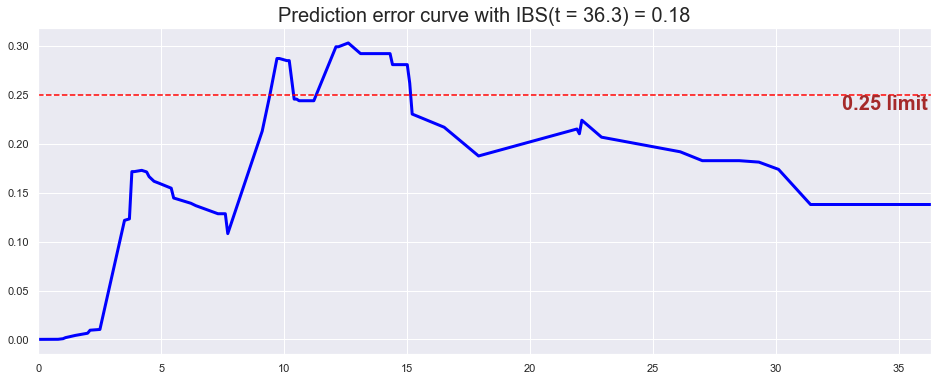

C-index: 0.72
IBS: 0.18

 3 of kfold 4


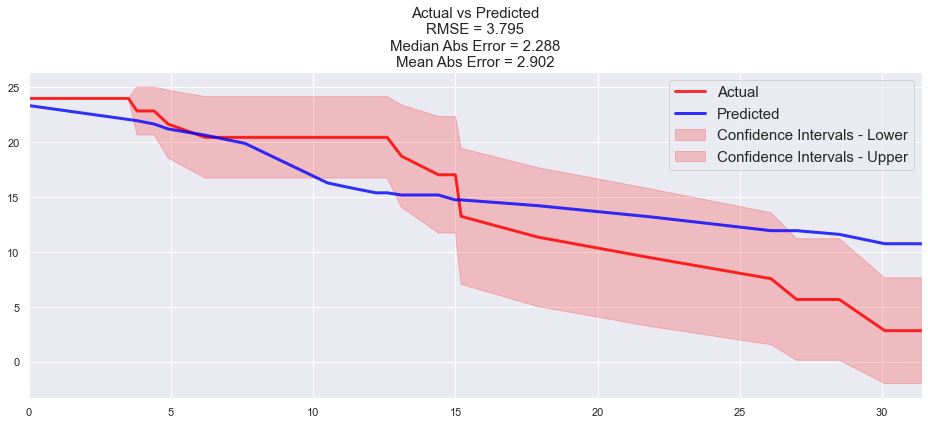

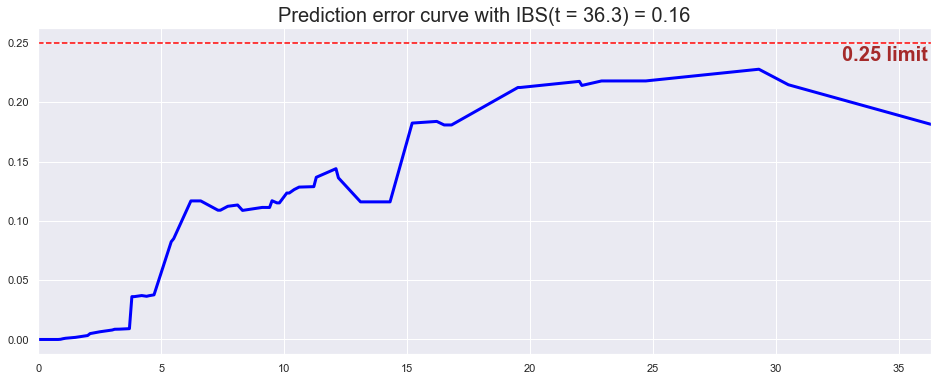

C-index: 0.82
IBS: 0.16

 4 of kfold 4


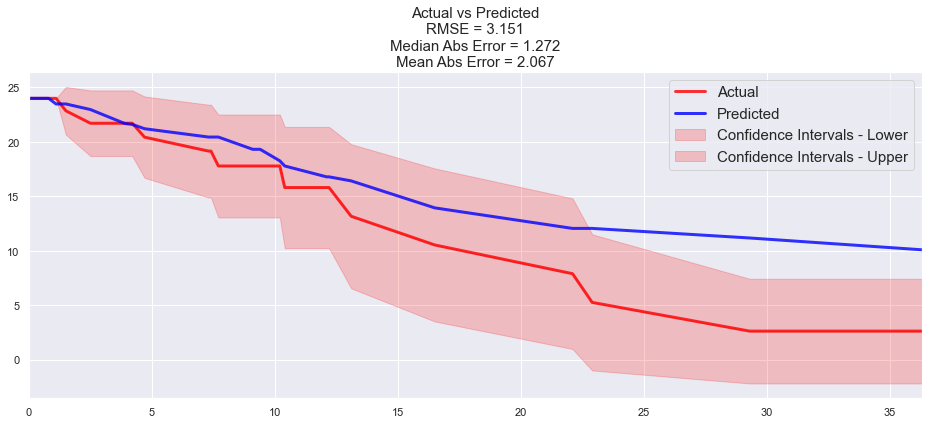

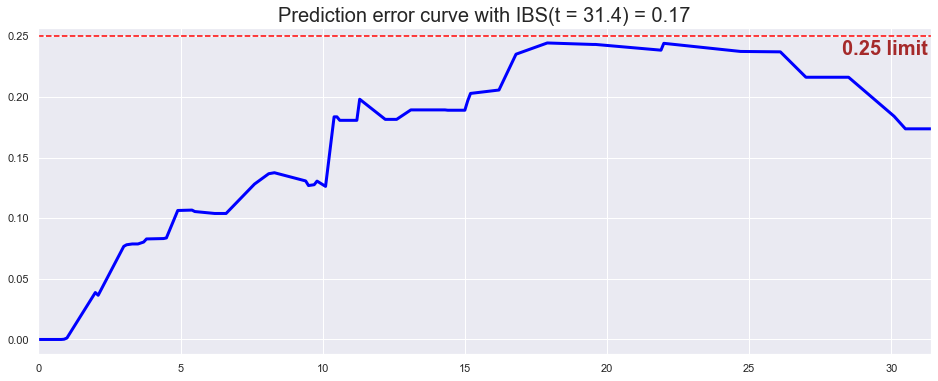

C-index: 0.78
IBS: 0.17

 

Processing: clin_variables_imaging_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


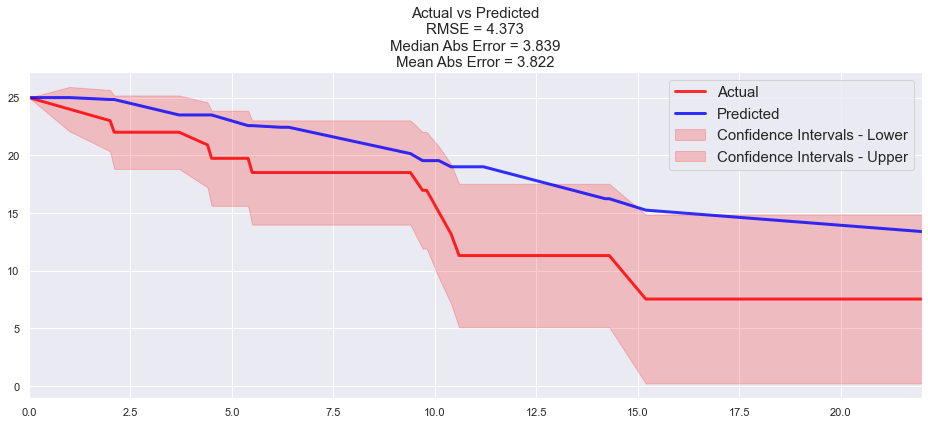

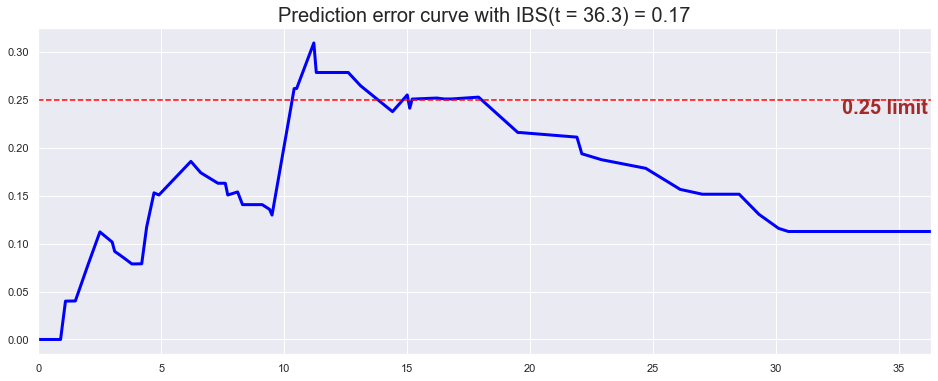

C-index: 0.70
IBS: 0.17

 2 of kfold 4


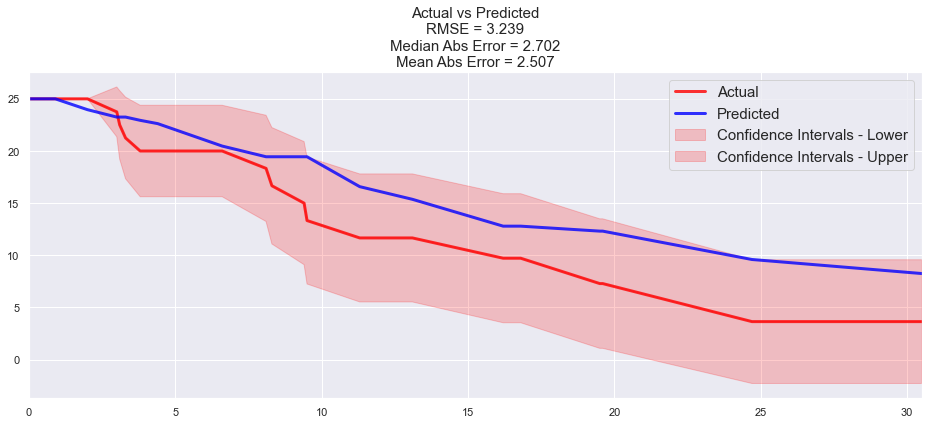

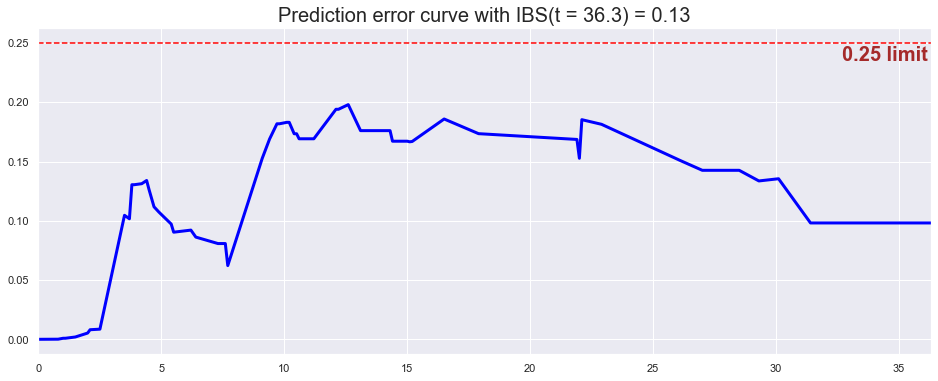

C-index: 0.78
IBS: 0.13

 3 of kfold 4


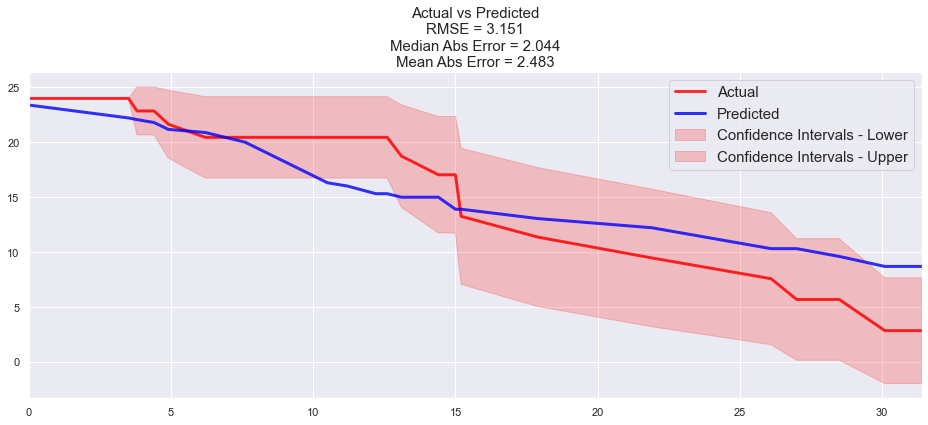

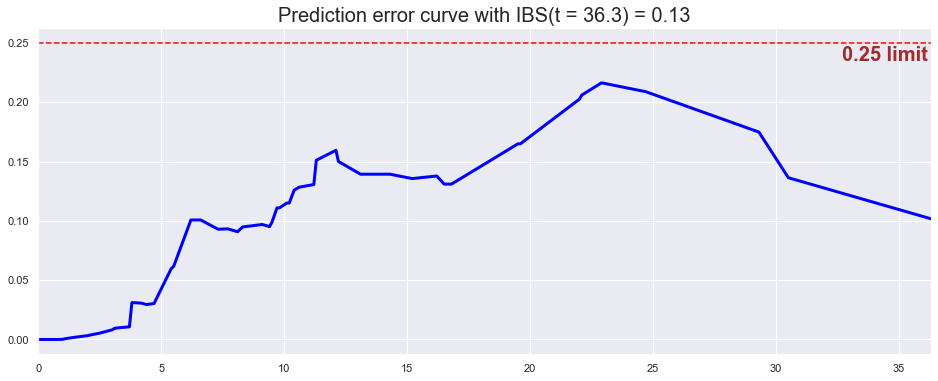

C-index: 0.76
IBS: 0.13

 4 of kfold 4


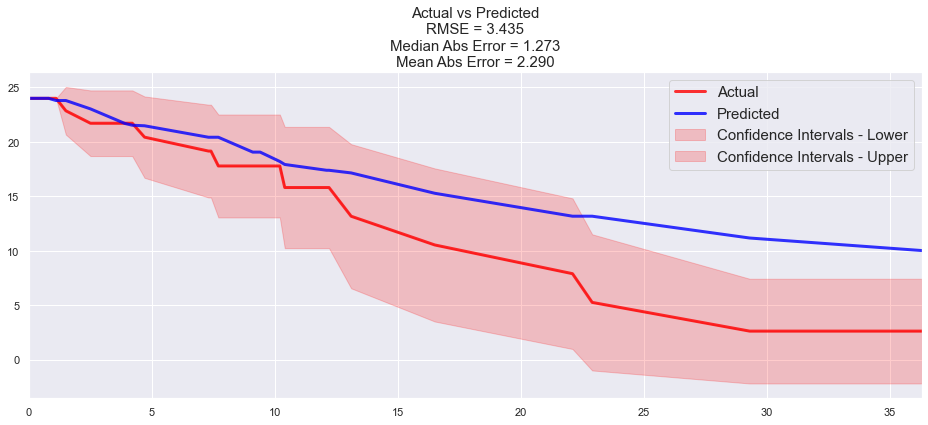

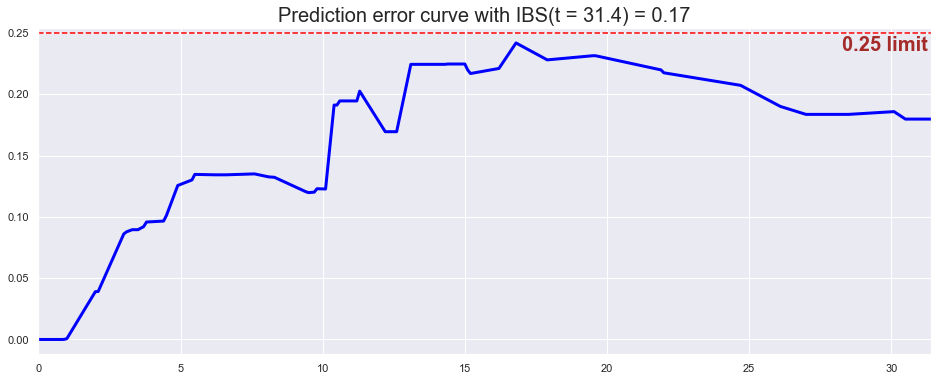

C-index: 0.71
IBS: 0.17

 

Processing: clin_variables_non_imaging_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_non_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


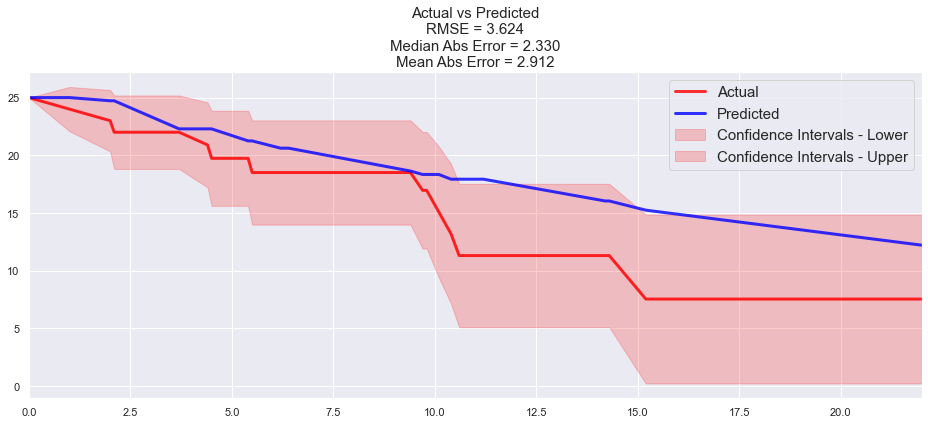

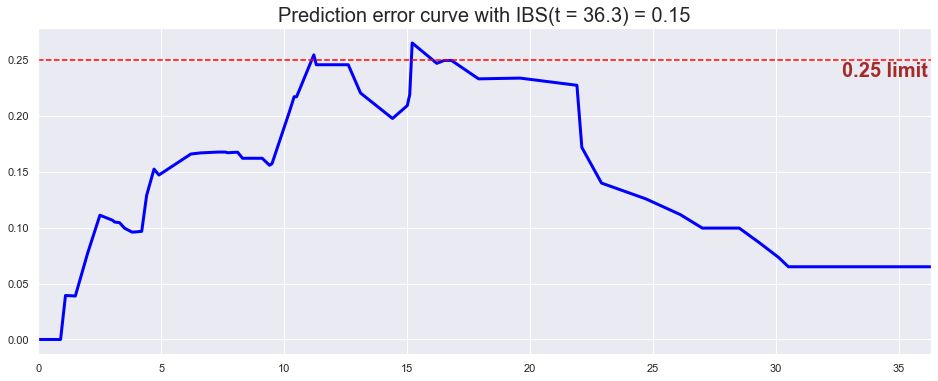

C-index: 0.80
IBS: 0.15

 2 of kfold 4


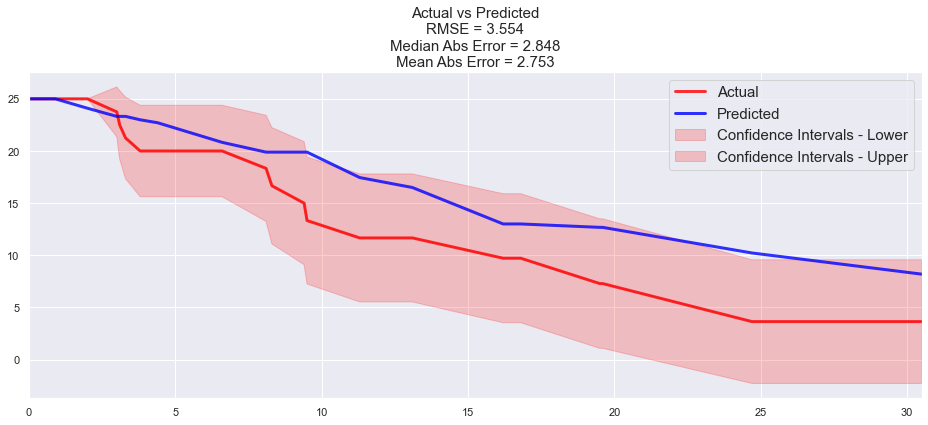

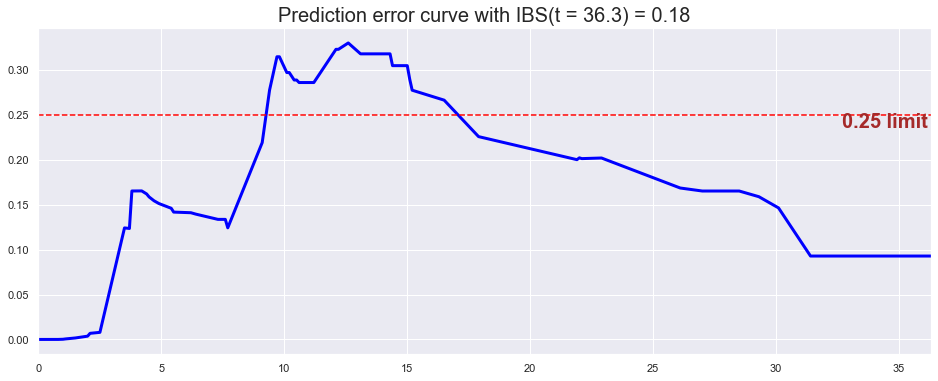

C-index: 0.62
IBS: 0.18

 3 of kfold 4


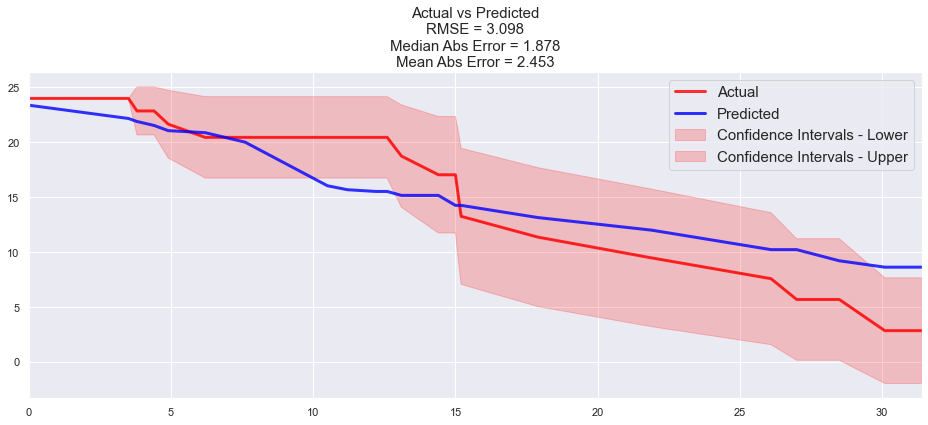

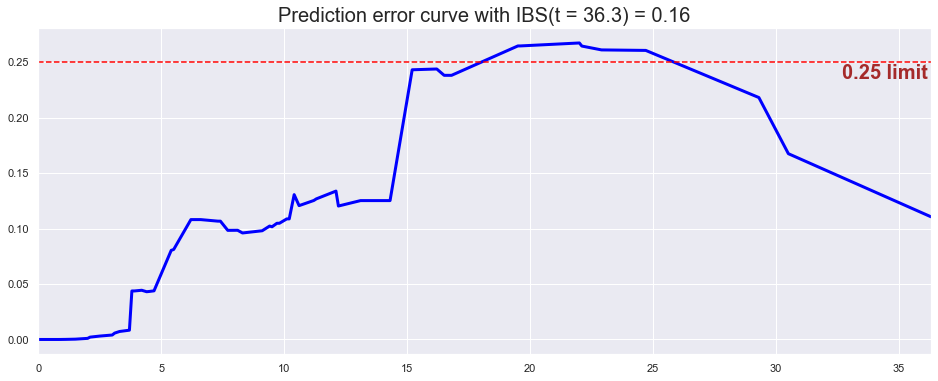

C-index: 0.61
IBS: 0.16

 4 of kfold 4


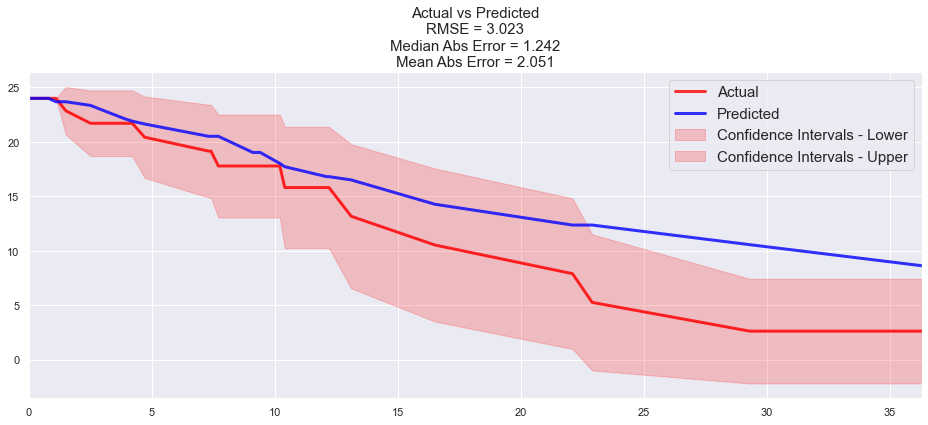

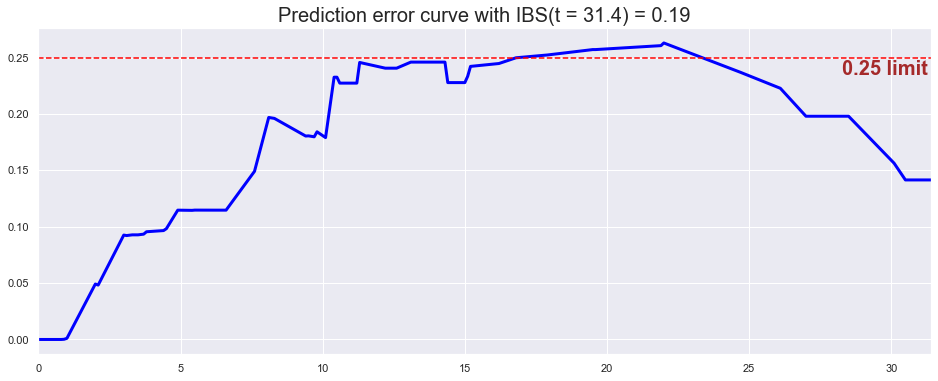

C-index: 0.62
IBS: 0.19

 

Processing: clin_variables_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


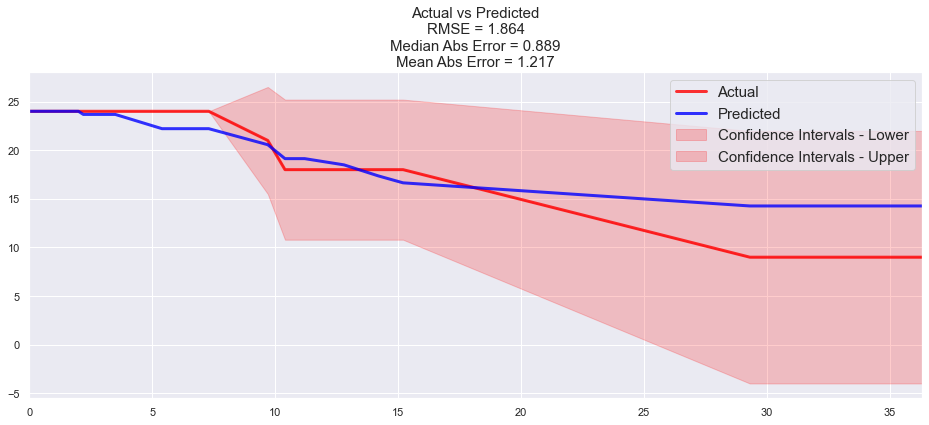

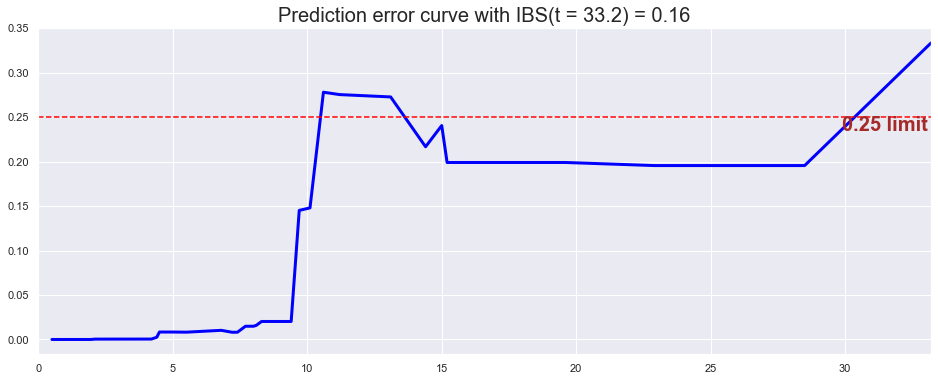

C-index: 0.95
IBS: 0.16

 2 of kfold 4


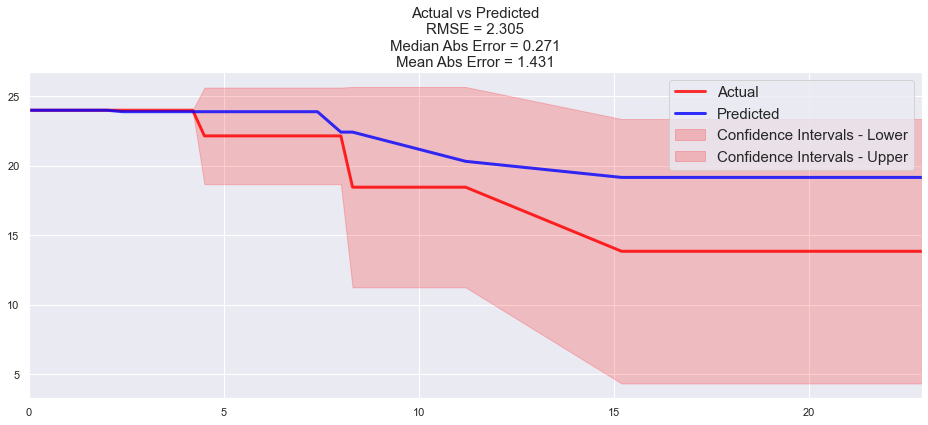

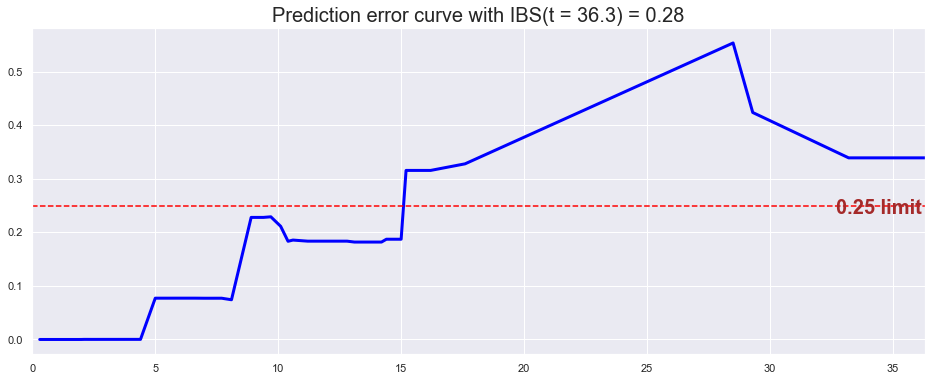

C-index: 0.52
IBS: 0.28

 3 of kfold 4


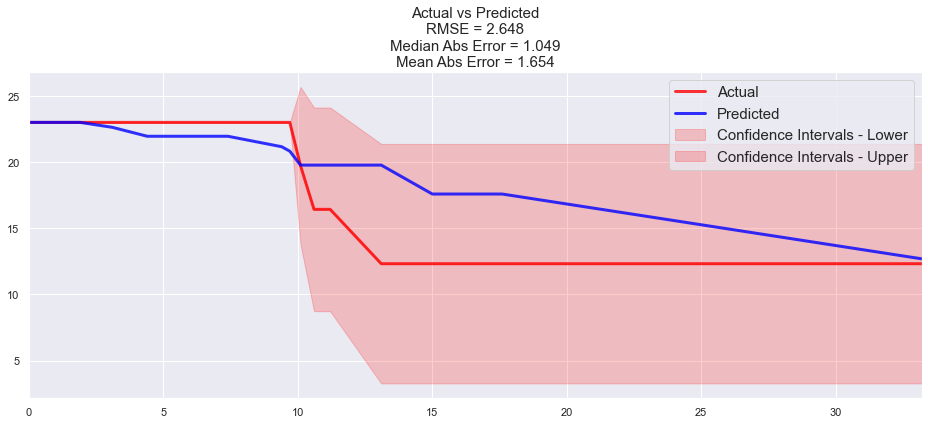

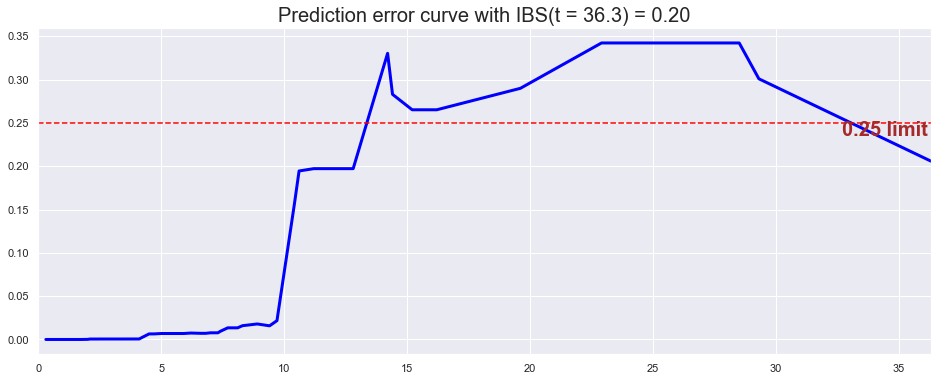

C-index: 0.55
IBS: 0.20

 4 of kfold 4


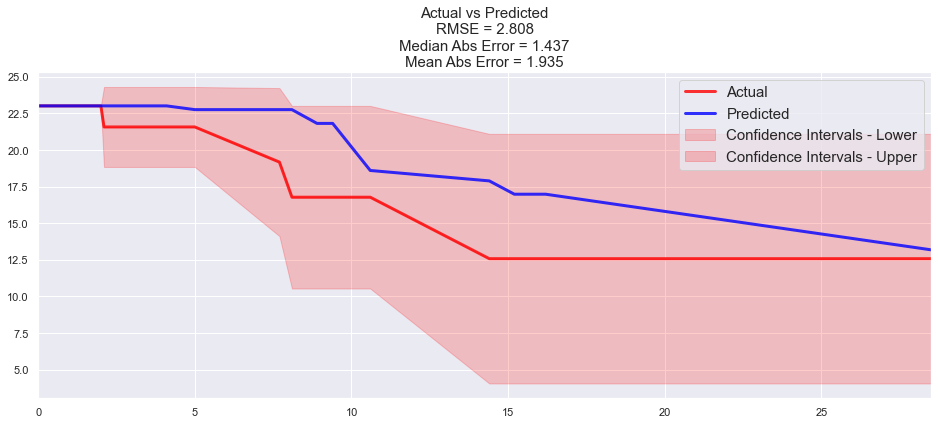

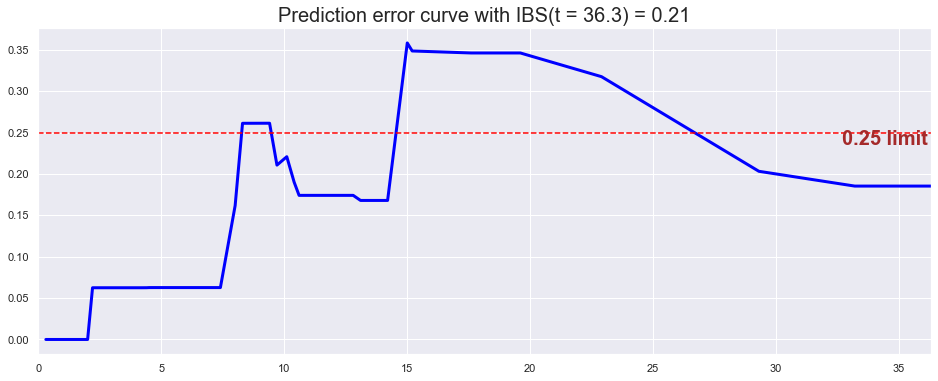

C-index: 0.52
IBS: 0.21

 

Processing: clin_variables_imaging_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_imaging_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


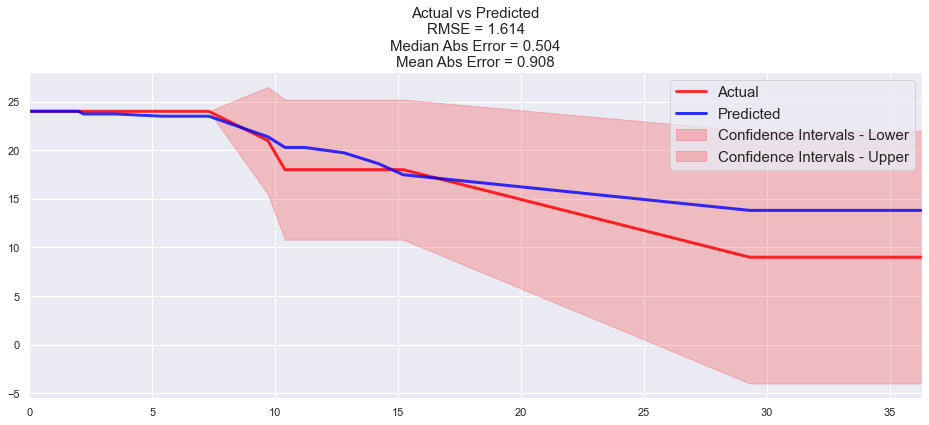

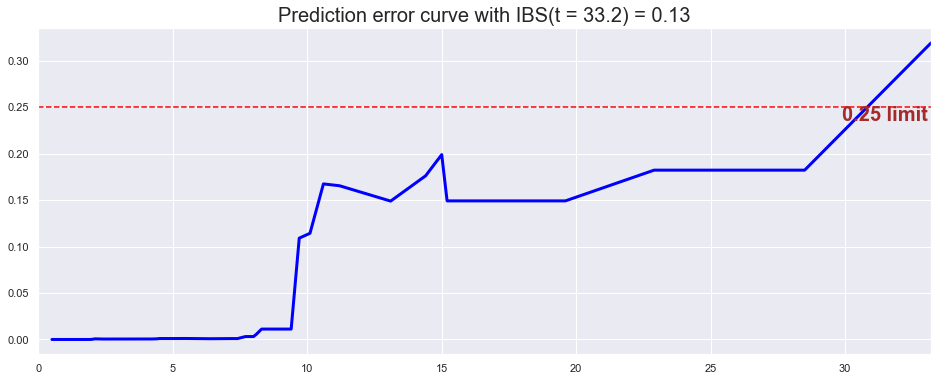

C-index: 0.68
IBS: 0.13

 2 of kfold 4


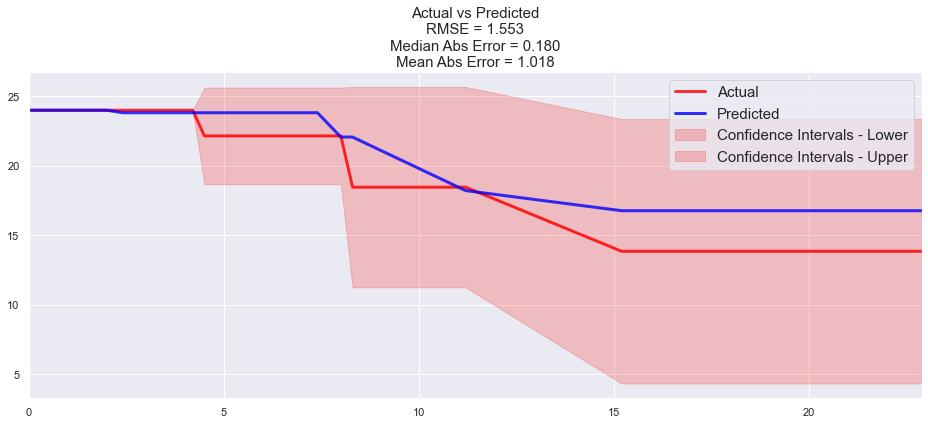

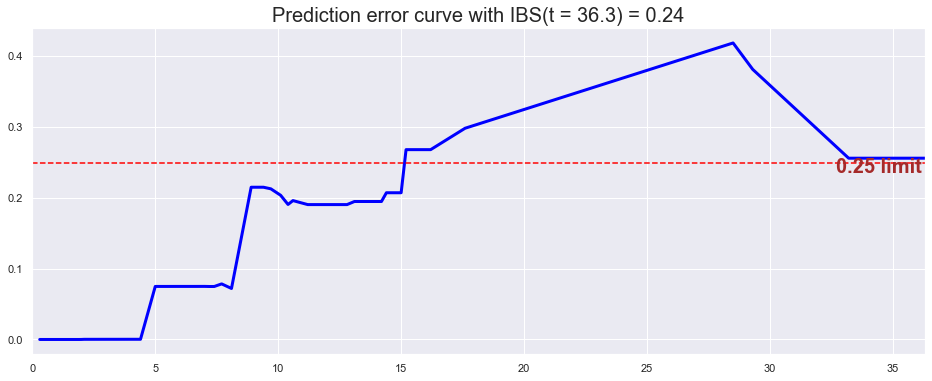

C-index: 0.68
IBS: 0.24

 3 of kfold 4


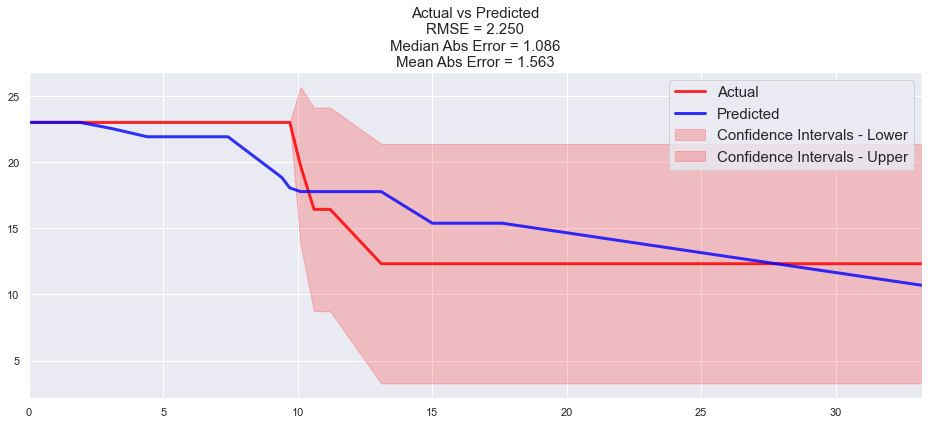

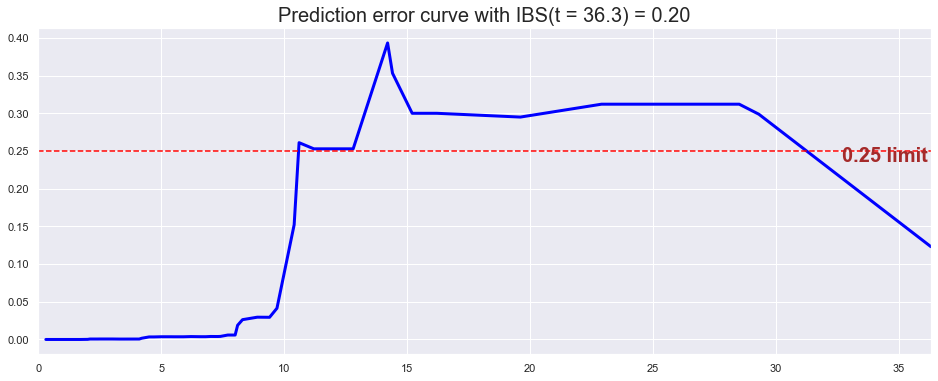

C-index: 0.77
IBS: 0.20

 4 of kfold 4


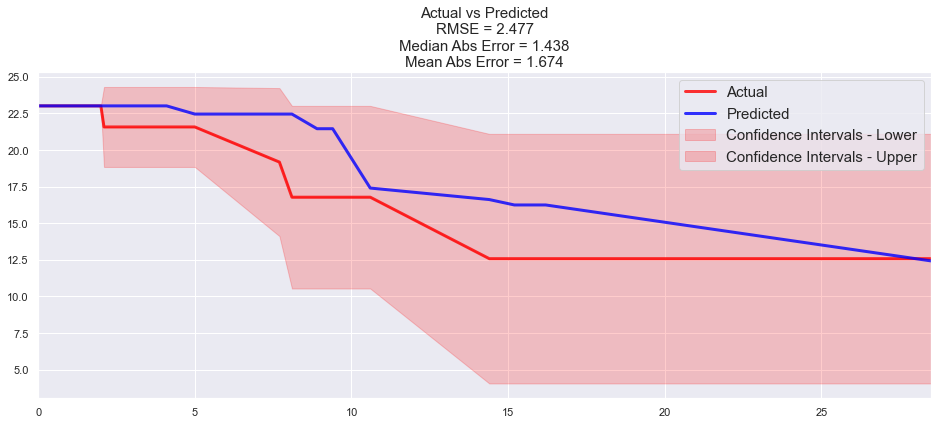

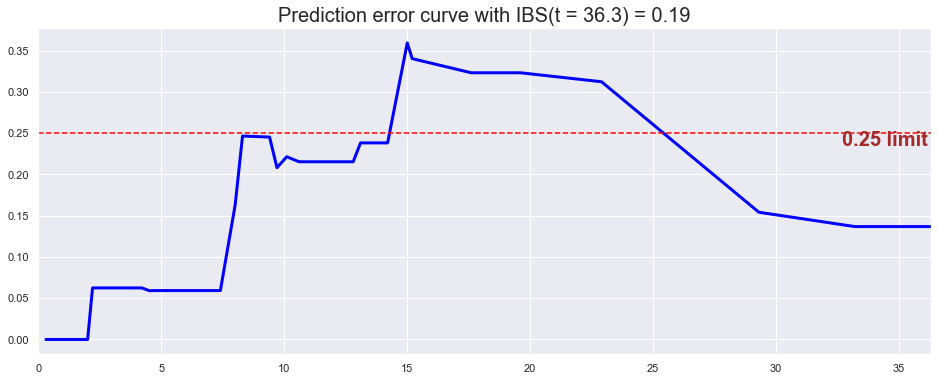

C-index: 0.83
IBS: 0.19

 

Processing: clin_variables_non_imaging_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_non_imaging_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


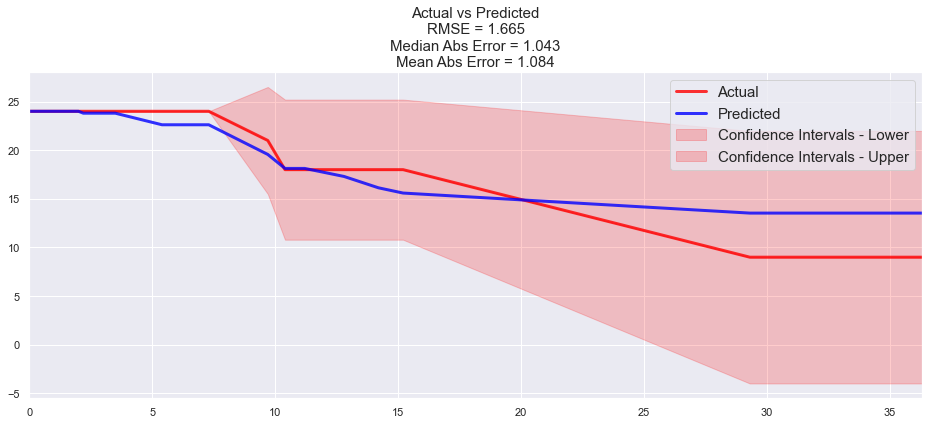

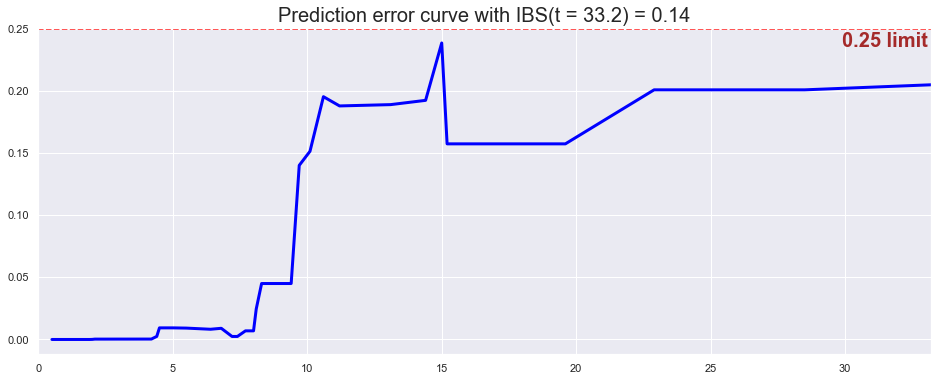

C-index: 0.82
IBS: 0.14

 2 of kfold 4


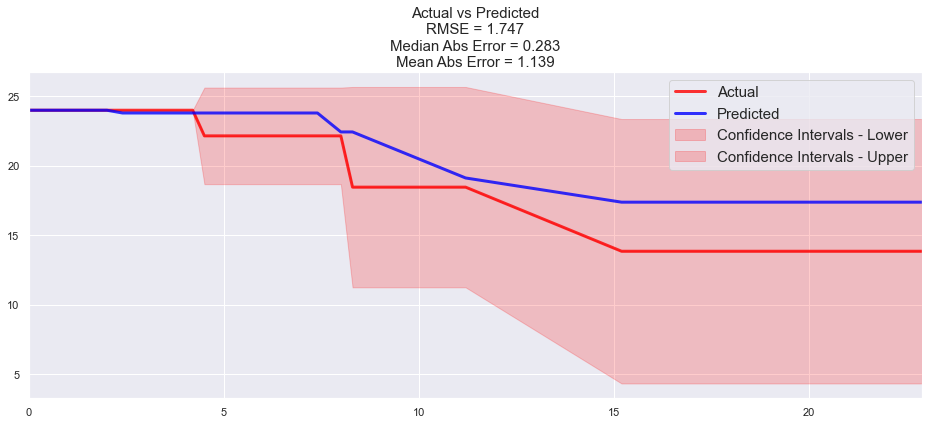

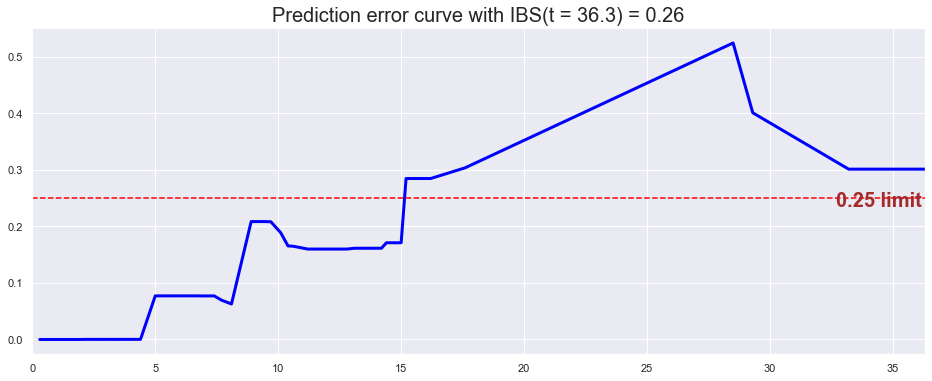

C-index: 0.60
IBS: 0.26

 3 of kfold 4


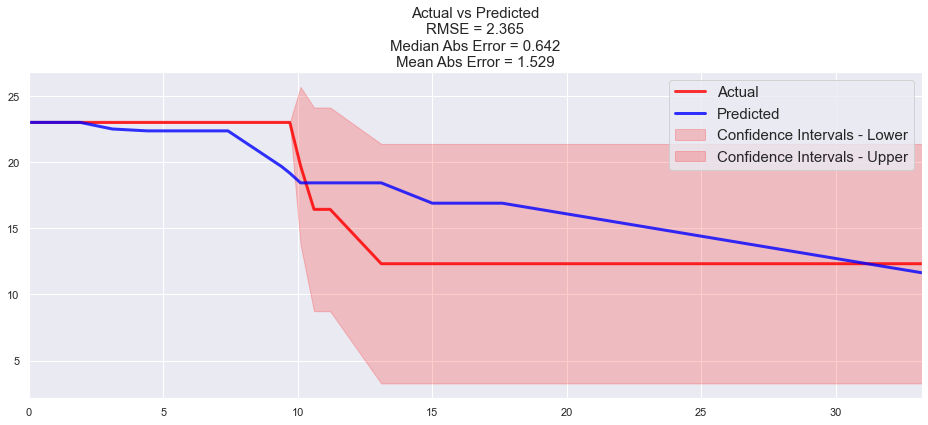

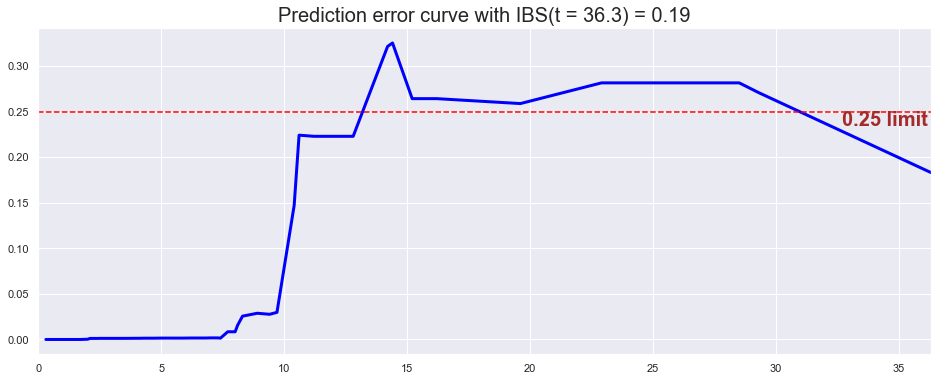

C-index: 0.67
IBS: 0.19

 4 of kfold 4


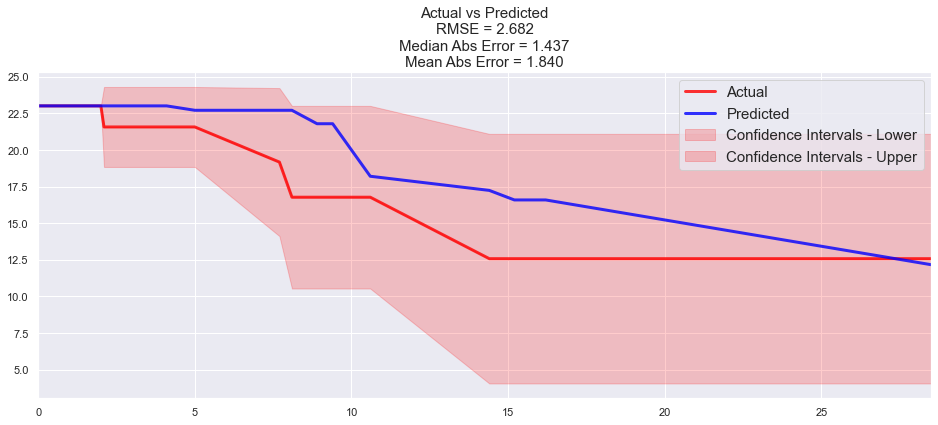

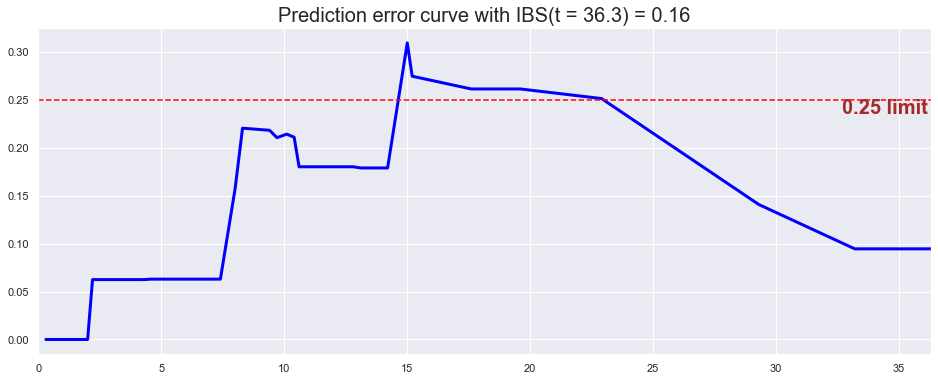

C-index: 0.62
IBS: 0.16

 

                                   Data  Best Gridsearch CI    CI Avg  \
0                               gtv.csv            0.759870  0.613749   
1                     liver_sub_gtv.csv            0.725754  0.613486   
2                    liver_plus_gtv.csv            0.778315  0.691877   
3                             gtv_0.csv            0.753913  0.591585   
4                            gtv_hp.csv            0.873810  0.744568   
5                  liver_sub_gtv_hp.csv            0.860498  0.550349   
6                 liver_plus_gtv_hp.csv            0.848197  0.746609   
7                          gtv_0_hp.csv            0.846394  0.632960   
8               clin_variables_fflp.csv            0.796323  0.779306   
9       clin_variables_imaging_fflp.csv            0.814685  0.738298   
10  clin_variables_non_imaging_fflp.csv            0.743317  0.660815   
11                clin_variables_hp.csv            0.839642  0.635549   
12        clin_variable

In [22]:
# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []
    
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

print(results_DF)

In [23]:
results_DF

Data  Best Gridsearch CI    CI Avg  \
0                               gtv.csv            0.759870  0.613749   
1                     liver_sub_gtv.csv            0.725754  0.613486   
2                    liver_plus_gtv.csv            0.778315  0.691877   
3                             gtv_0.csv            0.753913  0.591585   
4                            gtv_hp.csv            0.873810  0.744568   
5                  liver_sub_gtv_hp.csv            0.860498  0.550349   
6                 liver_plus_gtv_hp.csv            0.848197  0.746609   
7                          gtv_0_hp.csv            0.846394  0.632960   
8               clin_variables_fflp.csv            0.796323  0.779306   
9       clin_variables_imaging_fflp.csv            0.814685  0.738298   
10  clin_variables_non_imaging_fflp.csv            0.743317  0.660815   
11                clin_variables_hp.csv            0.839642  0.635549   
12        clin_variables_imaging_hp.csv            0.787629  0.741135   
13    clin_variables_non_imaging_hp.csv            0.894650  0.677178   

      CI STD   IBS Avg   IBS STD  Num Trees  Max Depth  Min Node  
0   0.058093  0.166189  0.021134       12.0        1.0       4.0  
1   0.072434  0.171592  0.005502       12.0       10.0      12.0  
2   0.107290  0.219662  0.029505       20.0        6.0       2.0  
3   0.055489  0.186579  0.018754       12.0        5.0       1.0  
4   0.126533  0.197281  0.066632       12.0       15.0      10.0  
5   0.078003  0.204447  0.058660       15.0        3.0       1.0  
6   0.114305  0.174269  0.025814       10.0        6.0      15.0  
7   0.110783  0.212431  0.061715       12.0        6.0       3.0  
8   0.039692  0.170466  0.009723       20.0       12.0       2.0  
9   0.037883  0.149693  0.022971       12.0       12.0       4.0  
10  0.091104  0.168178  0.018484       20.0       10.0       5.0  
11  0.213009  0.212698  0.049091       10.0       12.0       3.0  
12  0.073459  0.190506  0.044209       12.0        6.0      10.0  
13  0.099022  0.185376  0.052314       15.0        3.0       5.0